Random examples (subset indices): [343, 5472, 3596, 2726]
Original indices: [2130, 34066, 22275, 16855]


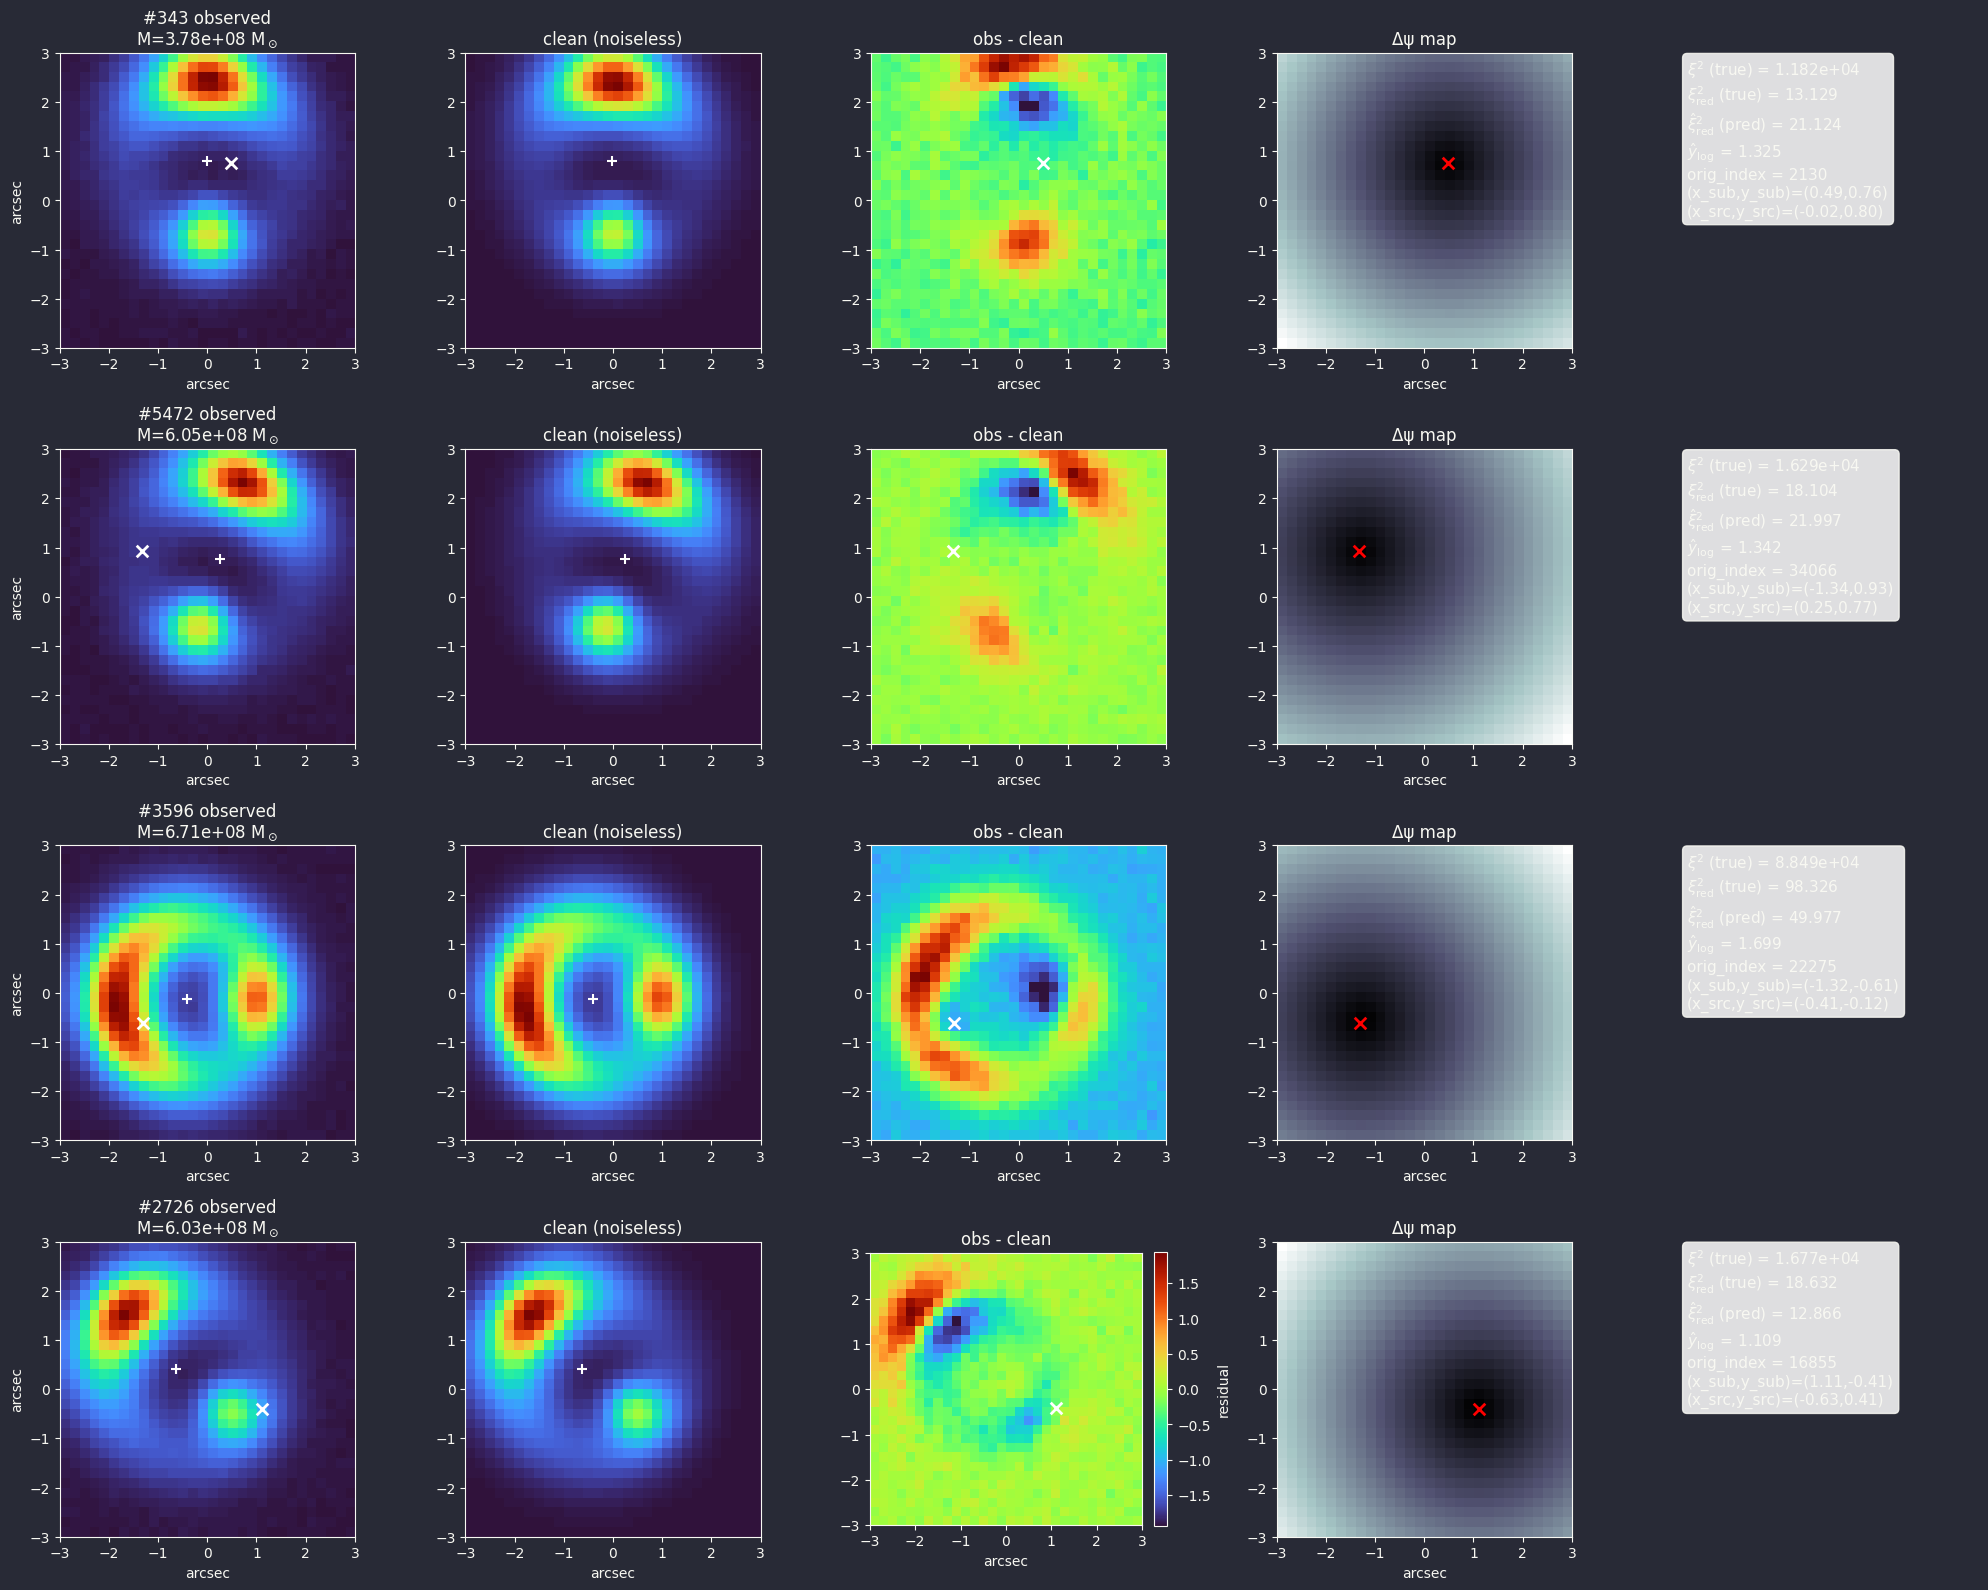

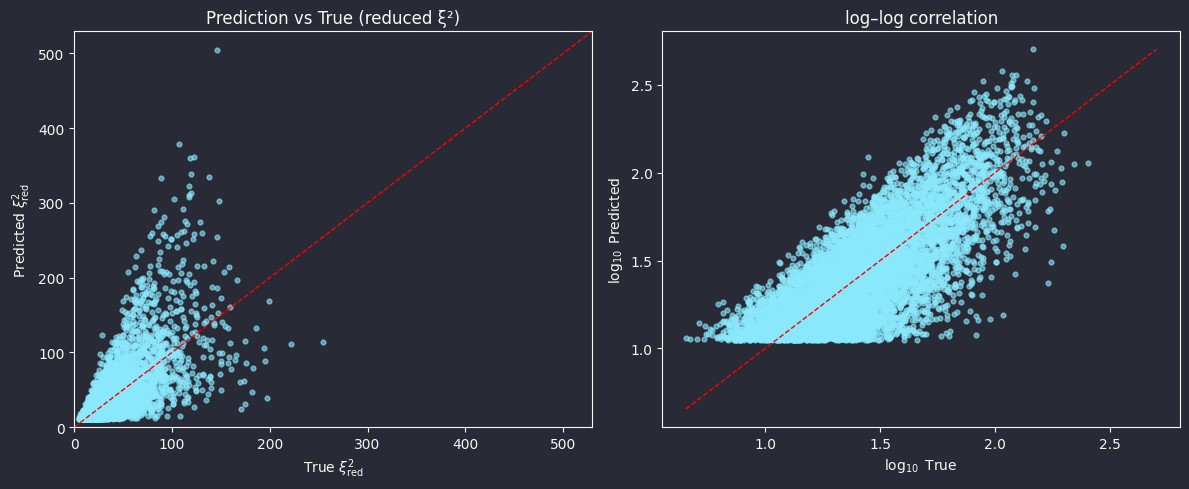

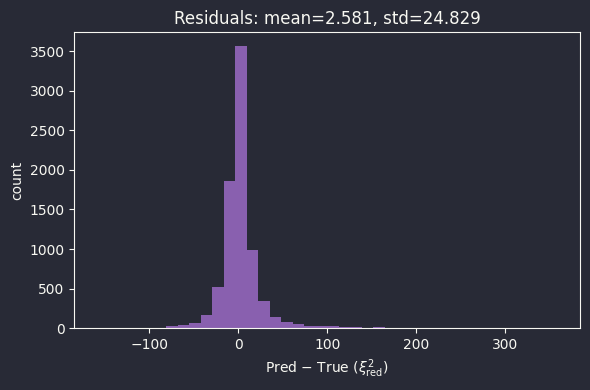

[subset] N=8000 | Spearman (linear)=0.726 | Spearman (log)=0.726


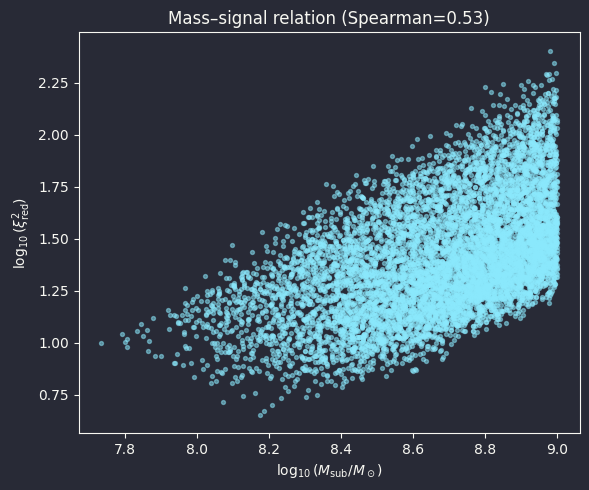

[subset] N=8000
reduced ξ² (subset): median=24.188, p16=13.882, p84=50.280
predicted reduced ξ²: median=22.638, p16=13.569, p84=51.975
orig_index range: [7, 49992]


In [37]:

# explore_subset_h5 — random sampler + diagnostics for the VAE-ready subset
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotx
plt.style.use(matplotx.styles.dracula)
from scipy.stats import spearmanr

# ======================
# Parameters
# ======================
# h5_path = 'LSST_singleband_subset_pred.h5'  # subset file
h5_path = "LSST_singleband_subset_pred_3.h5"   # subset file
N_EXAMPLES = 4
RANDOM_SEED = None

# -----------------------------
# Helper functions
# -----------------------------
def _pick_attr(attrs, name, default=None, cast=float):
    """Safely extract an attribute and cast it to the desired type."""
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _extent_from_attrs(f, shape_hw=None):
    """Infer the extent (arcsec) of an image from stored metadata."""
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    if shape_hw is None:
        return [-3, 3, -3, 3]
    H, W = shape_hw
    ps = _pick_attr(f.attrs, 'pixel_scale', 0.15)
    return [-W*ps/2, W*ps/2, -H*ps/2, H*ps/2]

def _safe_log10(x, lo=1e-30, hi=1e300):
    """Numerically safe log10 transformation with clipping."""
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, hi))

# -----------------------------
# Visualization
# -----------------------------
with h5py.File(h5_path, 'r') as f:
    # --- Required keys in the subset ---
    k_obs   = 'image_sub'             # (N,H,W) with subhalo + noise (linear)
    k_clean = 'image_nosub_nonoise'   # (N,H,W) without subhalo + no noise (linear)
    k_dpsi  = 'delta_psi'             # (N,H,W)

    # Fail early if core datasets are missing
    for k in (k_obs, k_clean, k_dpsi):
        if k not in f:
            raise KeyError(f"Dataset '{k}' not found in {h5_path}")

    # Scalars (true + predicted + mapping) — optional
    xi2     = f['xi2'][:]                     if 'xi2'                     in f else None
    xi2r    = f['xi2_reduced'][:]             if 'xi2_reduced'             in f else None
    xi2r_p  = f['xi2_reduced_pred'][:]        if 'xi2_reduced_pred'        in f else None
    xi2r_pl = f['xi2_reduced_pred_log'][:]    if 'xi2_reduced_pred_log'    in f else None
    idx_src = f['orig_index'][:]              if 'orig_index'              in f else None

    mass  = f['subhalo_mass'][:] if 'subhalo_mass' in f else None
    x_sub = f['subhalo_x'][:]    if 'subhalo_x'    in f else None
    y_sub = f['subhalo_y'][:]    if 'subhalo_y'    in f else None
    x_src = f['source_x'][:]     if 'source_x'     in f else None
    y_src = f['source_y'][:]     if 'source_y'     in f else None

    X = f[k_obs]  # don't read all into RAM; index per example
    N, H, W = X.shape
    extent = _extent_from_attrs(f, (H, W))

    # Global SNR proxy consistent with xi2: SNR = sqrt(sum ΔI²/σ²) ≡ sqrt(xi2)
    snr = np.sqrt(np.clip(xi2, 0, None)) if xi2 is not None else None

    # Random examples
    rng = np.random.default_rng(RANDOM_SEED)
    n_examples = min(N_EXAMPLES, N)
    idxs = rng.choice(N, size=n_examples, replace=False)
    print("Random examples (subset indices):", idxs.tolist())
    if idx_src is not None:
        print("Original indices:", idx_src[idxs].tolist())

    # Pre-pull scalar rows for the chosen examples (avoids repeated HDF5 scalar reads)
    m_vals   = mass[idxs]  if mass  is not None else np.full(n_examples, np.nan)
    xs_vals  = x_sub[idxs] if x_sub is not None else np.full(n_examples, np.nan)
    ys_vals  = y_sub[idxs] if y_sub is not None else np.full(n_examples, np.nan)
    x0_vals  = x_src[idxs] if x_src is not None else np.full(n_examples, np.nan)
    y0_vals  = y_src[idxs] if y_src is not None else np.full(n_examples, np.nan)

    # Figure: observed | clean | residual | Δψ | metrics (true vs pred)
    ncols = 5
    fig, axes = plt.subplots(n_examples, ncols, figsize=(4*ncols, 4*n_examples))
    if n_examples == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        m  = m_vals[row]; xs = xs_vals[row]; ys = ys_vals[row]
        x0 = x0_vals[row]; y0 = y0_vals[row]

        # (1) Observed (noisy)
        ax = axes[row, 0]
        obs = f[k_obs][idx]
        ax.imshow(obs, origin='lower', extent=extent, cmap='turbo')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], s=70, marker='x', lw=2, c='w')
        if np.isfinite(x0) and np.isfinite(y0): ax.scatter([x0],[y0], s=55, marker='+', lw=1.5, c='w')
        ax.set_title(f"#{idx} observed\nM={m:.2e} M$_\\odot$")
        ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # (2) Clean (noiseless)
        ax = axes[row, 1]
        clean = f[k_clean][idx]
        ax.imshow(clean, origin='lower', extent=extent, cmap='turbo')
        if np.isfinite(x0) and np.isfinite(y0): ax.scatter([x0],[y0], s=55, marker='+', lw=1.5, c='w')
        ax.set_title("clean (noiseless)")
        ax.set_xlabel("arcsec")

        # (3) Residual |obs - clean|
        ax = axes[row, 2]
        # resid = np.abs(obs - clean)
        resid = obs - clean
        im = ax.imshow(resid, origin='lower', extent=extent, cmap='turbo')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], s=70, marker='x', lw=2, c='w')
        ax.set_title(r"obs - clean")
        ax.set_xlabel("arcsec")
        if row == n_examples - 1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel("residual")

        # (4) Δψ
        ax = axes[row, 3]
        dpsi = f[k_dpsi][idx]
        ax.imshow(dpsi, origin='lower', extent=extent, cmap='bone')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], s=70, marker='x', lw=2, c='r')
        ax.set_title("Δψ map")
        ax.set_xlabel("arcsec")

        # (5) Metrics panel (true vs pred)
        ax = axes[row, 4]
        ax.axis('off')
        lines = []
        if xi2 is not None:   lines.append(r"$\xi^2$ (true) = %.3e" % xi2[idx])
        if xi2r is not None:  lines.append(r"$\xi^2_{\rm red}$ (true) = %.3f" % xi2r[idx])
        if xi2r_p is not None:   lines.append(r"$\hat{\xi}^2_{\rm red}$ (pred) = %.3f" % xi2r_p[idx])
        if xi2r_pl is not None:  lines.append(r"$\hat{y}_{\log}$ = %.3f" % xi2r_pl[idx])
        if idx_src is not None:  lines.append(f"orig_index = {int(idx_src[idx])}")
        lines.append(f"(x_sub,y_sub)=({xs:.2f},{ys:.2f})")
        lines.append(f"(x_src,y_src)=({x0:.2f},{y0:.2f})")
        ax.text(0.02, 0.98, "\n".join(lines), transform=ax.transAxes,
                va='top', ha='left', fontsize=11,
                bbox=dict(boxstyle='round', fc='white', alpha=.85))

    plt.tight_layout(); plt.show()

    # ===========================================
    # 2) DIAGNOSTICS (subset-level)
    # ===========================================
    # (A) True vs predicted (reduced xi^2)
    if (xi2r is not None) and (xi2r_p is not None):
        msk = np.isfinite(xi2r) & np.isfinite(xi2r_p) & (xi2r > 0) & (xi2r_p > 0)
        if np.any(msk):
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))

            # Linear scale
            ax = axs[0]
            ax.scatter(xi2r[msk], xi2r_p[msk], s=12, alpha=.6)
            lim = [0, max(xi2r[msk].max(), xi2r_p[msk].max())*1.05]
            ax.plot(lim, lim, 'r--', lw=1)
            ax.set_xlabel(r"True $\xi^2_{\rm red}$"); ax.set_ylabel(r"Predicted $\xi^2_{\rm red}$")
            ax.set_title("Prediction vs True (reduced ξ²)")
            ax.set_xlim(lim); ax.set_ylim(lim)

            # Log–log
            ax = axs[1]
            t = _safe_log10(xi2r[msk])
            p = _safe_log10(xi2r_p[msk])
            ax.scatter(t, p, s=12, alpha=.6)
            lo, hi = min(t.min(), p.min()), max(t.max(), p.max())
            ax.plot([lo,hi],[lo,hi],'r--', lw=1)
            ax.set_xlabel(r'$\log_{10}$ True'); ax.set_ylabel(r'$\log_{10}$ Predicted')
            ax.set_title("log–log correlation")
            plt.tight_layout(); plt.show()

            # Residuals (linear)
            res = xi2r_p[msk] - xi2r[msk]
            fig, ax = plt.subplots(figsize=(6,4))
            ax.hist(res, bins=40, alpha=.9, color='tab:purple')
            ax.set_xlabel(r'Pred − True ($\xi^2_{\rm red}$)'); ax.set_ylabel("count")
            ax.set_title(f"Residuals: mean={np.mean(res):.3f}, std={np.std(res):.3f}")
            plt.tight_layout(); plt.show()

            rho_lin, _ = spearmanr(xi2r[msk], xi2r_p[msk])
            rho_log, _ = spearmanr(t, p)
            print(f"[subset] N={int(np.sum(msk))} | Spearman (linear)={rho_lin:.3f} | Spearman (log)={rho_log:.3f}")
        else:
            print("[subset] Not enough finite/positive pairs for correlation plots.")

    # (B) Mass–signal relation in the subset
    if (mass is not None) and (xi2r is not None):
        logM = np.log10(np.clip(mass, 1e-30, None))
        logX = _safe_log10(xi2r)
        msk2 = np.isfinite(logM) & np.isfinite(logX)
        if np.any(msk2):
            fig, ax = plt.subplots(figsize=(6,5))
            ax.scatter(logM[msk2], logX[msk2], s=8, alpha=.5)
            rho, _ = spearmanr(logM[msk2], logX[msk2])
            ax.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
            ax.set_ylabel(r'$\log_{10}(\xi^2_{\rm red})$')
            ax.set_title(f'Mass–signal relation (Spearman={rho:.2f})')
            plt.tight_layout(); plt.show()

    # Quick summary
    print(f"[subset] N={N}")
    if xi2r is not None:
        print("reduced ξ² (subset): median=%.3f, p16=%.3f, p84=%.3f" %
              (np.nanmedian(xi2r), np.nanpercentile(xi2r, 16), np.nanpercentile(xi2r, 84)))
    if xi2r_p is not None:
        print("predicted reduced ξ²: median=%.3f, p16=%.3f, p84=%.3f" %
              (np.nanmedian(xi2r_p), np.nanpercentile(xi2r_p, 16), np.nanpercentile(xi2r_p, 84)))
    if idx_src is not None:
        print(f"orig_index range: [{int(idx_src.min())}, {int(idx_src.max())}]")


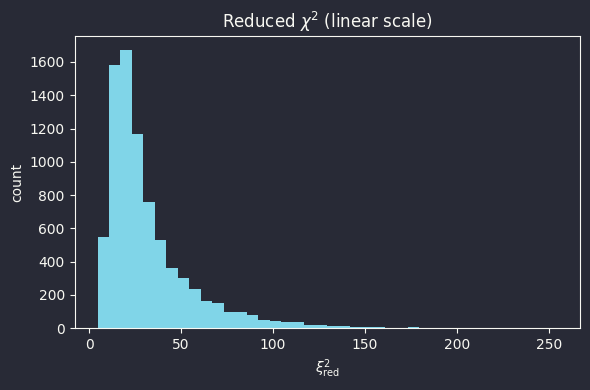

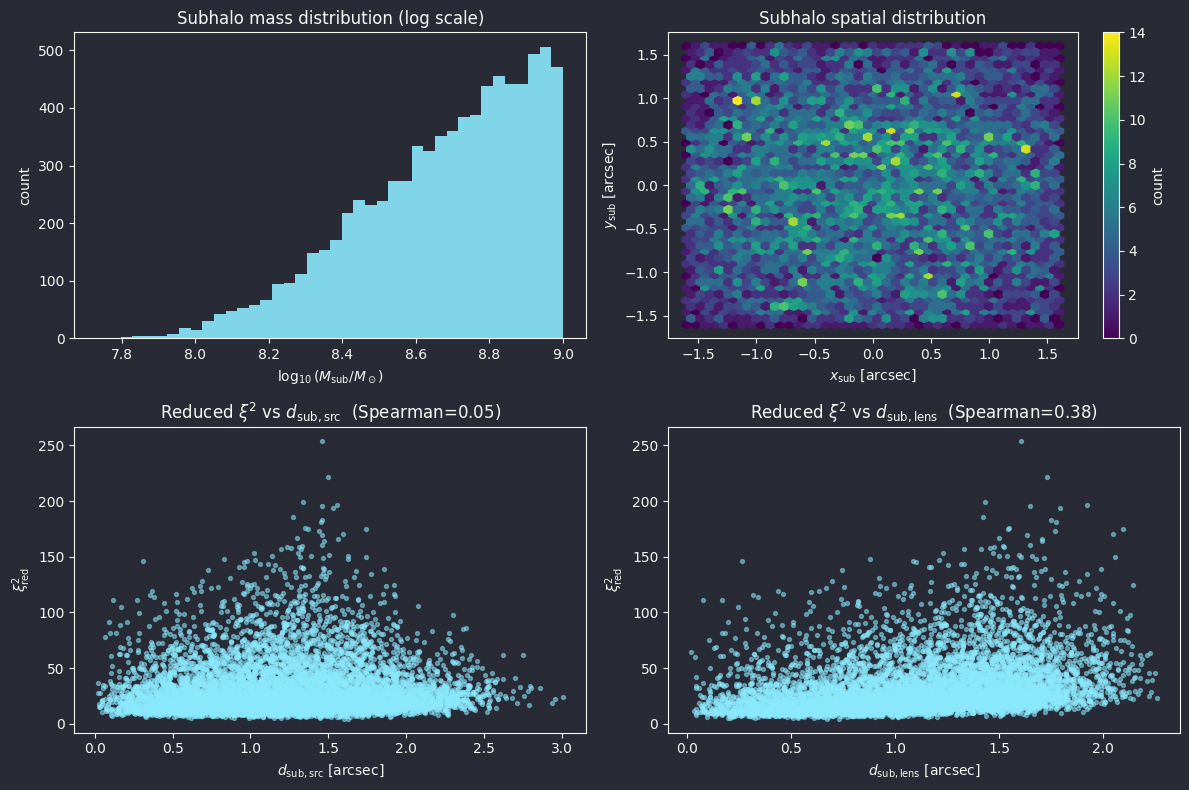

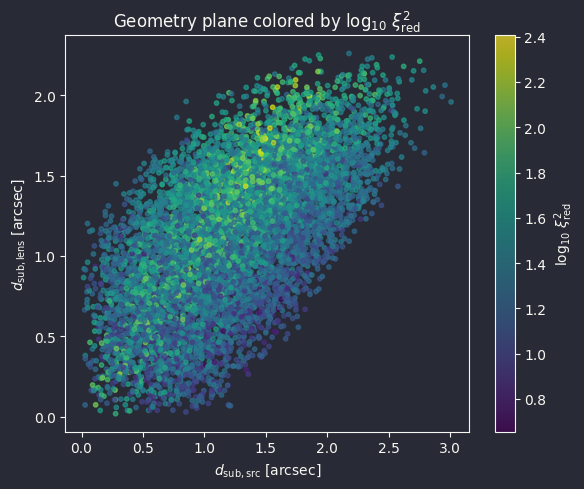

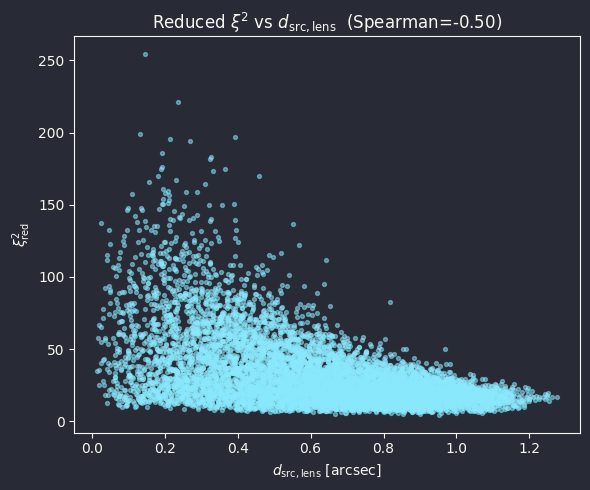

In [38]:
# import numpy as np
# import h5py
# import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# H5 = "LSST_singleband_dataset.h5"
H5 = "LSST_singleband_subset_pred_3.h5" 
def _pick_attr(attrs, name, default=None, cast=float):
    """Safe attribute getter with default and optional casting."""
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _safe_log10(x, lo=1e-12):
    """Numerically safe log10 with lower clipping."""
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, None))

# ---------- Load scalars ----------
with h5py.File(H5, "r") as f:
    M    = f["subhalo_mass"][:]         # (N,) in Msun
    xs   = f["subhalo_x"][:]            # (N,) arcsec
    ys   = f["subhalo_y"][:]            # (N,) arcsec
    x0   = f["source_x"][:]             # (N,) arcsec
    y0   = f["source_y"][:]             # (N,) arcsec
    xi2r = f["xi2_reduced"][:]          # (N,) reduced chi-square

    # Lens center from attributes (fallback to generator defaults)
    cx = _pick_attr(f.attrs, "lens_center_x", 0.0)
    cy = _pick_attr(f.attrs, "lens_center_y", -0.1)

# Basic finite masks (avoid NaNs/Infs in scatter/hist)
m_mask    = np.isfinite(M)
pos_mask  = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(x0) & np.isfinite(y0)
xi2r_mask = np.isfinite(xi2r)

# ---------- Derived geometric quantities ----------
# Distances (in arcsec)
d_sub_src  = np.hypot(xs - x0, ys - y0)            # subhalo–source
d_sub_lens = np.hypot(xs - cx, ys - cy)            # subhalo–lens center
d_src_lens = np.hypot(x0 - cx, y0 - cy)            # source–lens center

# Logs for plotting
logM  = _safe_log10(np.clip(M, 1e-30, None))
logXi = _safe_log10(xi2r)

# ---------- Figure 0: Reduced χ² histogram (linear scale) ----------
plt.figure(figsize=(6, 4))
vals = xi2r[xi2r_mask]
plt.hist(vals, bins=40, alpha=0.9)
plt.xlabel(r'$\xi^2_{\rm red}$')
plt.ylabel('count')
plt.title('Reduced $\chi^2$ (linear scale)')
plt.tight_layout()
plt.show()

# ---------- Figure 1: Mass and position distributions ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax11, ax12 = axs[0]
ax21, ax22 = axs[1]

# (1,1) Histogram of log10 subhalo mass
ax11.hist(logM[m_mask], bins=40, alpha=.9)
ax11.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
ax11.set_ylabel('count')
ax11.set_title('Subhalo mass distribution (log scale)')

# (1,2) 2D hexbin of subhalo positions
hb_mask = pos_mask
hb = ax12.hexbin(xs[hb_mask], ys[hb_mask], gridsize=40, cmap='viridis')
ax12.set_xlabel(r'$x_{\rm sub}$ [arcsec]')
ax12.set_ylabel(r'$y_{\rm sub}$ [arcsec]')
ax12.set_title('Subhalo spatial distribution')
cb = plt.colorbar(hb, ax=ax12); cb.set_label('count')

# (2,1) Reduced χ² vs distance subhalo–source
msk1 = np.isfinite(d_sub_src) & xi2r_mask
rho, _ = spearmanr(d_sub_src[msk1], xi2r[msk1], nan_policy="omit")
ax21.scatter(d_sub_src[msk1], xi2r[msk1], s=8, alpha=.5)
ax21.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax21.set_ylabel(r'$\xi^2_{\rm red}$')
ax21.set_title(f'Reduced $\\xi^2$ vs $d_{{\\rm sub,src}}$  (Spearman={rho:.2f})')

# (2,2) Reduced χ² vs distance subhalo–lens center
msk2 = np.isfinite(d_sub_lens) & xi2r_mask
rho2, _ = spearmanr(d_sub_lens[msk2], xi2r[msk2], nan_policy="omit")
ax22.scatter(d_sub_lens[msk2], xi2r[msk2], s=8, alpha=.5)
ax22.set_xlabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax22.set_ylabel(r'$\xi^2_{\rm red}$')
ax22.set_title(f'Reduced $\\xi^2$ vs $d_{{\\rm sub,lens}}$  (Spearman={rho2:.2f})')

plt.tight_layout()
plt.show()

# ---------- Figure 2: Geometry plane colored by log10 reduced χ² ----------
fig, ax = plt.subplots(figsize=(6, 5))
geo_mask = np.isfinite(d_sub_src) & np.isfinite(d_sub_lens) & np.isfinite(logXi)
sc = ax.scatter(d_sub_src[geo_mask], d_sub_lens[geo_mask], c=logXi[geo_mask], s=10, alpha=.7)
ax.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax.set_ylabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax.set_title(r'Geometry plane colored by $\log_{10}\,\xi^2_{\rm red}$')
cb = plt.colorbar(sc, ax=ax); cb.set_label(r'$\log_{10}\,\xi^2_{\rm red}$')
plt.tight_layout()
plt.show()

# ---------- Figure 3: Reduced χ² vs source–lens distance ----------
msk3 = np.isfinite(d_src_lens) & xi2r_mask
rho3, _ = spearmanr(d_src_lens[msk3], xi2r[msk3], nan_policy="omit")
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(d_src_lens[msk3], xi2r[msk3], s=8, alpha=.5)
ax.set_xlabel(r'$d_{\rm src,lens}$ [arcsec]')
ax.set_ylabel(r'$\xi^2_{\rm red}$')
ax.set_title(f'Reduced $\\xi^2$ vs $d_{{\\rm src,lens}}$  (Spearman={rho3:.2f})')
plt.tight_layout()
plt.show()


In [39]:
import torch
from sklearn.model_selection import train_test_split
SUBSET_H5 = "LSST_singleband_subset_pred_3.h5"   # <- same as above

# Reproducibility for the split
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# 1) Load from HDF5 (single-band: (N,H,W))
with h5py.File(SUBSET_H5, "r") as f:
    X_noisy  = f["image_sub"][:]            # noisy with subhalo
    Y_clean  = f["image_nosub_nonoise"][:]  # noiseless baseline (no subhalo)
    Y_delta  = f["delta_psi"][:]            # Δψ (N,H,W)

    # Scalars (optional, useful for conditioning/analysis)
    sub_mass = f["subhalo_mass"][:]
    sub_x    = f["subhalo_x"][:]
    sub_y    = f["subhalo_y"][:]

# 2) Finite masks & cleaning (avoid NaNs/Infs), cast to float32, ensure contiguous
def _clean(a):
    a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)
    a = a.astype('float32', copy=False)
    return np.ascontiguousarray(a)

X_noisy  = _clean(X_noisy)
Y_clean  = _clean(Y_clean)
Y_delta  = _clean(Y_delta)

sub_mass = _clean(sub_mass)
sub_x    = _clean(sub_x)
sub_y    = _clean(sub_y)

# 3) To torch tensors, channel-first: (N,H,W) -> (N,1,H,W)
X  = torch.from_numpy(X_noisy).unsqueeze(1).contiguous()
Y1 = torch.from_numpy(Y_clean).unsqueeze(1).contiguous()
Y2 = torch.from_numpy(Y_delta).unsqueeze(1).contiguous()

# 4) Train/val/test split → 70/20/10 overall (10% test, then 22.22% of the rest for val)
N = X.shape[0]
idx_all = np.arange(N)

idx_rest, idx_test = train_test_split(idx_all, test_size=0.10, random_state=RANDOM_STATE, shuffle=True)
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=RANDOM_STATE, shuffle=True)

# 5) Apply splits
X_train, X_val, X_test    = X[idx_train],   X[idx_val],   X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train],  Y1[idx_val],  Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train],  Y2[idx_val],  Y2[idx_test]

sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train,   sub_x_val,   sub_x_test     = sub_x[idx_train],    sub_x[idx_val],    sub_x[idx_test]
sub_y_train,   sub_y_val,   sub_y_test     = sub_y[idx_train],    sub_y[idx_val],    sub_y[idx_test]

# 6) Basic sanity checks
assert X_train.shape[0] == Y1_train.shape[0] == Y2_train.shape[0] == sub_mass_train.shape[0]
assert X_val.shape[0]   == Y1_val.shape[0]   == Y2_val.shape[0]   == sub_mass_val.shape[0]
assert X_test.shape[0]  == Y1_test.shape[0]  == Y2_test.shape[0]  == sub_mass_test.shape[0]

print("[shapes]")
print(" X:",        X_train.shape,  X_val.shape,  X_test.shape)
print(" Y1 (clean):", Y1_train.shape, Y1_val.shape, Y1_test.shape)
print(" Y2 (Δψ):   ", Y2_train.shape, Y2_val.shape, Y2_test.shape)
print(" scalars:",    sub_mass_train.shape, sub_x_train.shape, sub_y_train.shape)
print("[indices] train/val/test:", len(idx_train), len(idx_val), len(idx_test))

# 7) (Optional) Δψ normalization stats computed **from tensors already in RAM** (no h5py handle)
#    Útil si vas a estandarizar Y2 para entrenar el VAE.
with torch.no_grad():
    # Usamos sólo train
    y2_tr_np = Y2_train.cpu().numpy()  # (Ntr,1,H,W)
    # calcula sobre valores finitos
    msk = np.isfinite(y2_tr_np)
    count = int(msk.sum())
    if count > 0:
        mean_dpsi = float(y2_tr_np[msk].mean())
        std_dpsi  = float(y2_tr_np[msk].std(ddof=0))
    else:
        mean_dpsi, std_dpsi = 0.0, 1.0
print(f"[Δψ stats on train] mean={mean_dpsi:.4g}, std={std_dpsi:.4g}")

# (si quieres reutilizarlos en otras celdas)
norm_stats = {"delta_psi_mean_train": mean_dpsi, "delta_psi_std_train": std_dpsi}


[shapes]
 X: torch.Size([5600, 1, 30, 30]) torch.Size([1600, 1, 30, 30]) torch.Size([800, 1, 30, 30])
 Y1 (clean): torch.Size([5600, 1, 30, 30]) torch.Size([1600, 1, 30, 30]) torch.Size([800, 1, 30, 30])
 Y2 (Δψ):    torch.Size([5600, 1, 30, 30]) torch.Size([1600, 1, 30, 30]) torch.Size([800, 1, 30, 30])
 scalars: (5600,) (5600,) (5600,)
[indices] train/val/test: 5600 1600 800
[Δψ stats on train] mean=0.08539, std=0.04386


=== Reduced chi-square (xi2_reduced) stats per split ===
[train] N=5600 | median=24.072 | p16=13.829 | p84=49.224 | min=4.518 | max=221.253
[val  ] N=1600 | median=24.180 | p16=13.987 | p84=52.603 | min=5.630 | max=254.390
[test ] N=800 | median=25.111 | p16=14.240 | p84=54.536 | min=4.720 | max=169.878


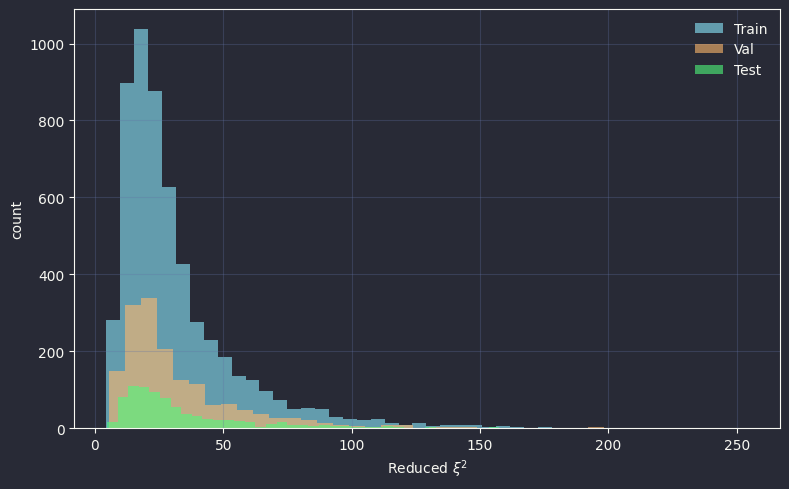

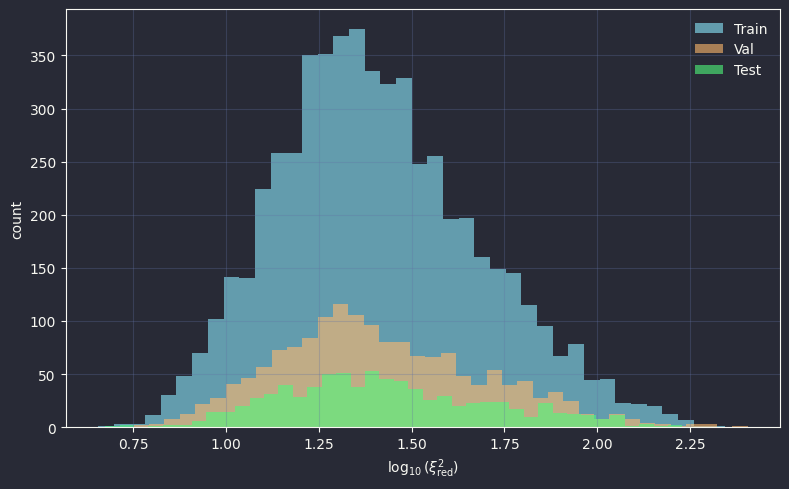

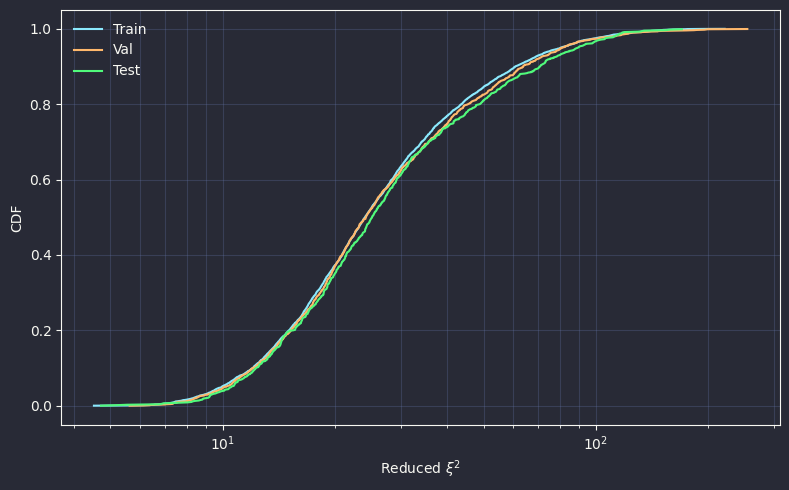

In [40]:

# 1) Carga xi2_reduced del subset
with h5py.File(SUBSET_H5, "r") as f:
    xi2r_all = f["xi2_reduced"][:]  # (N,)

# 2) Proyecta a cada split usando los índices que ya tienes
xi2r_tr = xi2r_all[idx_train]
xi2r_va = xi2r_all[idx_val]
xi2r_te = xi2r_all[idx_test]

def _stats(name, a):
    a = a[np.isfinite(a)]
    print(f"[{name}] N={a.size} | median={np.median(a):.3f} | p16={np.percentile(a,16):.3f} | p84={np.percentile(a,84):.3f} | min={a.min():.3f} | max={a.max():.3f}")

print("=== Reduced chi-square (xi2_reduced) stats per split ===")
_stats("train", xi2r_tr)
_stats("val  ", xi2r_va)
_stats("test ", xi2r_te)

# 3) Histogramas superpuestos (escala lineal)
plt.figure(figsize=(8,5))
plt.hist(xi2r_tr[np.isfinite(xi2r_tr)], bins=40, alpha=0.6, label="Train")
plt.hist(xi2r_va[np.isfinite(xi2r_va)], bins=40, alpha=0.6, label="Val")
plt.hist(xi2r_te[np.isfinite(xi2r_te)], bins=40, alpha=0.6, label="Test")
plt.xlabel(r'Reduced $\xi^2$')
plt.ylabel('count')
# plt.title('Reduced $\xi^2$ distribution (linear scale)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Histogramas superpuestos en log10(xi2_reduced)
def _safe_log10(x, lo=1e-12):
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, None))

plt.figure(figsize=(8,5))
plt.hist(_safe_log10(xi2r_tr), bins=40, alpha=0.6, label="Train")
plt.hist(_safe_log10(xi2r_va), bins=40, alpha=0.6, label="Val")
plt.hist(_safe_log10(xi2r_te), bins=40, alpha=0.6, label="Test")
plt.xlabel(r'$\log_{10}(\xi^2_{\rm red})$')
plt.ylabel('count')
# plt.title('Reduced $\xi^2$ distribution (log10 space)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5) (Opcional) CDFs para comparar colas
def _cdf(x):
    x = np.sort(x[np.isfinite(x)])
    y = np.linspace(0,1,len(x),endpoint=False)
    return x, y

x_tr, F_tr = _cdf(xi2r_tr)
x_va, F_va = _cdf(xi2r_va)
x_te, F_te = _cdf(xi2r_te)

plt.figure(figsize=(8,5))
plt.plot(x_tr, F_tr, label="Train")
plt.plot(x_va, F_va, label="Val")
plt.plot(x_te, F_te, label="Test")
plt.xscale('log')
plt.xlabel(r'Reduced $\xi^2$')
plt.ylabel('CDF')
# plt.title('Reduced $\xi^2$ empirical CDF (log-x)')
plt.legend()
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()

=== Subhalo mass (linear Msun) ===
[train] N=5600 | mean=531036768.000 | std=244029936.000 | median=515246112.000 | p16=260933626.240 | p84=822460311.040 | min=54237412.000 | max=999166848.000
[val  ] N=1600 | mean=545307200.000 | std=244275808.000 | median=535093248.000 | p16=270887577.600 | p84=841509427.200 | min=63721060.000 | max=999133248.000
[test ] N=800 | mean=545933248.000 | std=245852400.000 | median=537785920.000 | p16=270875118.080 | p84=842036096.000 | min=73132328.000 | max=999528704.000

=== Subhalo x [arcsec] ===
[train] N=5600 | mean=-0.020 | std=0.855 | median=-0.024 | p16=-1.006 | p84=0.947 | min=-1.599 | max=1.599
[val  ] N=1600 | mean=-0.020 | std=0.863 | median=-0.022 | p16=-0.990 | p84=0.948 | min=-1.599 | max=1.600
[test ] N=800 | mean=-0.010 | std=0.865 | median=-0.009 | p16=-0.992 | p84=0.988 | min=-1.588 | max=1.581

=== Subhalo y [arcsec] ===
[train] N=5600 | mean=-0.005 | std=0.837 | median=0.009 | p16=-0.957 | p84=0.939 | min=-1.600 | max=1.599
[val  ] N=

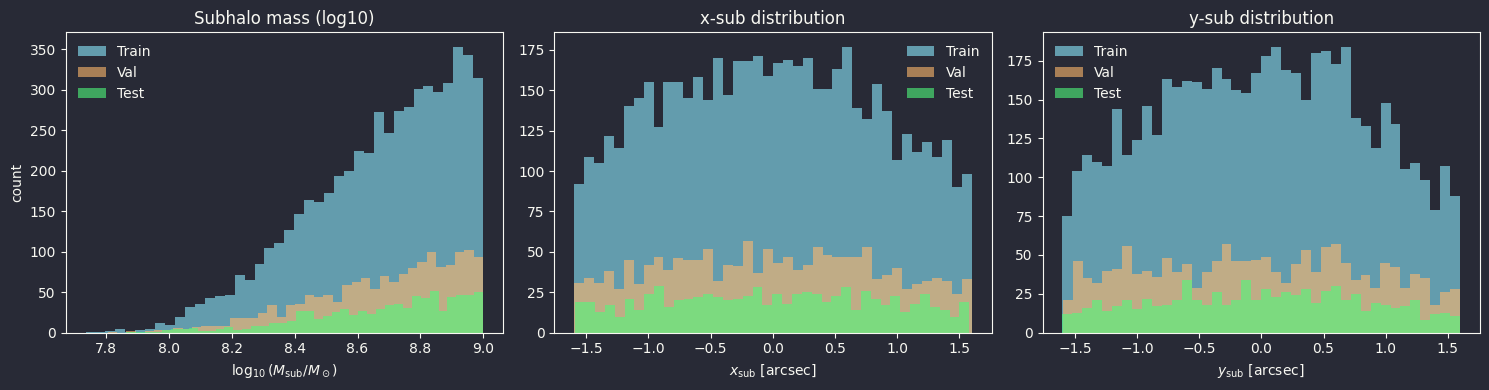

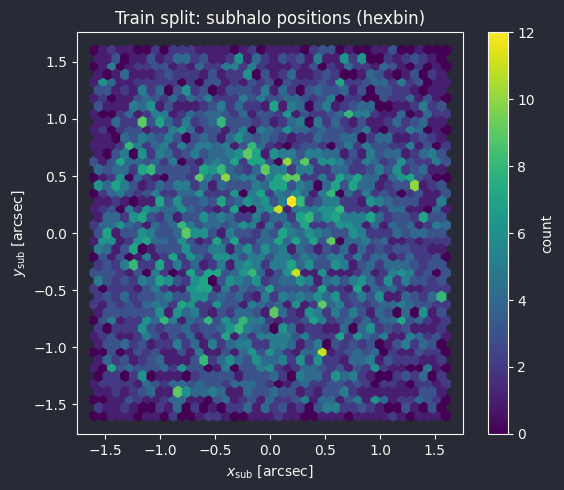

[Δψ stats on train] mean=0.08539, std=0.04386


In [41]:

# --- 1) Split scalars already in RAM ---
mass_tr,  mass_va,  mass_te  = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
x_tr,     x_va,     x_te     = sub_x[idx_train],    sub_x[idx_val],    sub_x[idx_test]
y_tr,     y_va,     y_te     = sub_y[idx_train],    sub_y[idx_val],    sub_y[idx_test]

# --- 2) (Optional) also inspect reduced chi^2 per split (read once, close) ---
with h5py.File(SUBSET_H5, "r") as f:
    xi2r_all = f["xi2_reduced"][:]  # (N,)

xi2r_tr, xi2r_va, xi2r_te = xi2r_all[idx_train], xi2r_all[idx_val], xi2r_all[idx_test]

def _stats_1d(name, a):
    a = a[np.isfinite(a)]
    return (f"[{name}] N={a.size} | mean={np.mean(a):.3f} | std={np.std(a):.3f} | "
            f"median={np.median(a):.3f} | p16={np.percentile(a,16):.3f} | p84={np.percentile(a,84):.3f} | "
            f"min={a.min():.3f} | max={a.max():.3f}")

print("=== Subhalo mass (linear Msun) ===")
print(_stats_1d("train", mass_tr))
print(_stats_1d("val  ", mass_va))
print(_stats_1d("test ", mass_te))

print("\n=== Subhalo x [arcsec] ===")
print(_stats_1d("train", x_tr))
print(_stats_1d("val  ", x_va))
print(_stats_1d("test ", x_te))

print("\n=== Subhalo y [arcsec] ===")
print(_stats_1d("train", y_tr))
print(_stats_1d("val  ", y_va))
print(_stats_1d("test ", y_te))

print("\n=== Reduced chi^2 (xi2_reduced) ===")
print(_stats_1d("train", xi2r_tr))
print(_stats_1d("val  ", xi2r_va))
print(_stats_1d("test ", xi2r_te))

# --- 3) Plots: mass/x/y histograms by split ---
def _safe_log10(a, eps=1e-30): return np.log10(np.clip(a, eps, None))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (A1) mass in log10
axes[0].hist(_safe_log10(mass_tr), bins=40, alpha=0.6, label="Train")
axes[0].hist(_safe_log10(mass_va), bins=40, alpha=0.6, label="Val")
axes[0].hist(_safe_log10(mass_te), bins=40, alpha=0.6, label="Test")
axes[0].set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
axes[0].set_ylabel("count"); axes[0].set_title("Subhalo mass (log10)"); axes[0].legend()

# (A2) x_sub
axes[1].hist(x_tr, bins=40, alpha=0.6, label="Train")
axes[1].hist(x_va, bins=40, alpha=0.6, label="Val")
axes[1].hist(x_te, bins=40, alpha=0.6, label="Test")
axes[1].set_xlabel(r'$x_{\rm sub}$ [arcsec]'); axes[1].set_title("x-sub distribution"); axes[1].legend()

# (A3) y_sub
axes[2].hist(y_tr, bins=40, alpha=0.6, label="Train")
axes[2].hist(y_va, bins=40, alpha=0.6, label="Val")
axes[2].hist(y_te, bins=40, alpha=0.6, label="Test")
axes[2].set_xlabel(r'$y_{\rm sub}$ [arcsec]'); axes[2].set_title("y-sub distribution"); axes[2].legend()

plt.tight_layout(); plt.show()

# --- 4) 2D hexbin of (x_sub, y_sub) for train ---
plt.figure(figsize=(5.8, 5))
hb = plt.hexbin(x_tr, y_tr, gridsize=40, cmap='viridis')
plt.xlabel(r'$x_{\rm sub}$ [arcsec]'); plt.ylabel(r'$y_{\rm sub}$ [arcsec]')
plt.title("Train split: subhalo positions (hexbin)")
cb = plt.colorbar(hb); cb.set_label('count')
plt.tight_layout(); plt.show()

# --- 5) (Optional) Δψ normalization stats using tensors already in RAM ---
# Uses Y2_train tensor: (Ntr,1,H,W)
y2_tr_np = Y2_train.cpu().numpy()
mask = np.isfinite(y2_tr_np)
if mask.any():
    dpsi_mean = float(y2_tr_np[mask].mean())
    dpsi_std  = float(y2_tr_np[mask].std())
else:
    dpsi_mean, dpsi_std = 0.0, 1.0
print(f"[Δψ stats on train] mean={dpsi_mean:.4g}, std={dpsi_std:.4g}")

# (Optionally persist for later normalization in the VAE)
norm_stats = {"delta_psi_mean_train": dpsi_mean, "delta_psi_std_train": dpsi_std}
# np.save("norm_stats_subset.npy", norm_stats, allow_pickle=True)

In [42]:

# ==== Cell: Define TensorDatasets and DataLoaders (normalized X/Y1/Y2 + normalized mxy) ====
import torch
from torch.utils.data import TensorDataset, DataLoader

# --------------------------
# 1) Normalización clásica de X, Y1, Y2 usando solo TRAIN (si ya lo hiciste arriba, omite esta sección)
# --------------------------
eps = 1e-6
with torch.no_grad():
    x_mean, x_std = X_train.mean(), X_train.std().clamp_min(eps)
    s_mean, s_std = Y1_train.mean(), Y1_train.std().clamp_min(eps)
    d_mean, d_std = Y2_train.mean(), Y2_train.std().clamp_min(eps)

def _norm(t, m, s): return (t - m) / s

X_train_n = _norm(X_train, x_mean, x_std);  X_val_n = _norm(X_val, x_mean, x_std);  X_test_n = _norm(X_test, x_mean, x_std)
Y1_train_n = _norm(Y1_train, s_mean, s_std); Y1_val_n = _norm(Y1_val, s_mean, s_std); Y1_test_n = _norm(Y1_test, s_mean, s_std)
Y2_train_n = _norm(Y2_train, d_mean, d_std); Y2_val_n = _norm(Y2_val, d_mean, d_std); Y2_test_n = _norm(Y2_test, d_mean, d_std)

print(f"[Norm X] mean/std train: {float(X_train_n.mean()):.3f}/{float(X_train_n.std()):.3f}")
print(f"[Norm Y2] mean/std val:   {float(Y2_val_n.mean()):.3f}/{float(Y2_val_n.std()):.3f}")

# --------------------------
# 2) mxy: log10(mass) + estándar por TRAIN
# --------------------------
# Construye tensores crudos
mxy_train_raw = torch.stack([
    torch.from_numpy(sub_mass_train),
    torch.from_numpy(sub_x_train),
    torch.from_numpy(sub_y_train)
], dim=1).float()

mxy_val_raw = torch.stack([
    torch.from_numpy(sub_mass_val),
    torch.from_numpy(sub_x_val),
    torch.from_numpy(sub_y_val)
], dim=1).float()

mxy_test_raw = torch.stack([
    torch.from_numpy(sub_mass_test),
    torch.from_numpy(sub_x_test),
    torch.from_numpy(sub_y_test)
], dim=1).float()

# log-transform a la masa (columna 0)
mxy_train_log = mxy_train_raw.clone()
mxy_val_log   = mxy_val_raw.clone()
mxy_test_log  = mxy_test_raw.clone()

mxy_train_log[:, 0] = torch.log10(mxy_train_log[:, 0].clamp_min(1e-12))
mxy_val_log[:, 0]   = torch.log10(mxy_val_log[:, 0].clamp_min(1e-12))
mxy_test_log[:, 0]  = torch.log10(mxy_test_log[:, 0].clamp_min(1e-12))

# estándar con stats del TRAIN
mxy_mean = mxy_train_log.mean(dim=0)
mxy_std  = mxy_train_log.std(dim=0).clamp_min(1e-6)

mxy_train = (mxy_train_log - mxy_mean) / mxy_std
mxy_val   = (mxy_val_log   - mxy_mean) / mxy_std
mxy_test  = (mxy_test_log  - mxy_mean) / mxy_std

print("[mxy stats] train mean≈", mxy_train.mean(0), " std≈", mxy_train.std(0))

# Guarda stats para des-normalizar luego si quieres reportar en unidades físicas
mxy_norm_stats = {
    "mass_log10_mean": float(mxy_mean[0]), "mass_log10_std": float(mxy_std[0]),
    "x_mean": float(mxy_mean[1]), "x_std": float(mxy_std[1]),
    "y_mean": float(mxy_mean[2]), "y_std": float(mxy_std[2]),
}

# --------------------------
# 3) Datasets con tensores normalizados
# --------------------------
train_ds = TensorDataset(X_train_n, Y1_train_n, Y2_train_n, mxy_train)
val_ds   = TensorDataset(X_val_n,   Y1_val_n,   Y2_val_n,   mxy_val)
test_ds  = TensorDataset(X_test_n,  Y1_test_n,  Y2_test_n,  mxy_test)

# --------------------------
# 4) DataLoaders
# --------------------------
batch = 512
on_cuda = torch.cuda.is_available()
common_kwargs = dict(
    batch_size=batch,
    num_workers=0 if not on_cuda else 4,  # sube a 4 si tu entorno lo soporta
    pin_memory=on_cuda,
    persistent_workers=on_cuda
)

train_loader = DataLoader(train_ds, shuffle=True,  drop_last=True,  **common_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, drop_last=False, **common_kwargs)
test_loader  = DataLoader(test_ds,  shuffle=False, drop_last=False, **common_kwargs)

print(f"[DataLoaders ready] batch={batch}, CUDA={on_cuda}")


[Norm X] mean/std train: -0.000/1.000
[Norm Y2] mean/std val:   0.036/1.015
[mxy stats] train mean≈ tensor([-9.2098e-07,  3.4060e-09, -1.7030e-08])  std≈ tensor([1., 1., 1.])
[DataLoaders ready] batch=512, CUDA=True


In [43]:

# 3) Detect and configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# (Optional) move small stats or constants to device later if needed


✅ Using device: cuda


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# #--------------------------------VAE---------------------------------------------
# class DualVAE(nn.Module):
#     def __init__(self, 
#                  in_ch=1,
#                  base_ch=32,
#                  z_dim=256,
#                  H=30, W=30,           # <-- imágenes 30x30
#                  use_dropout=False,
#                  dropout_p=0.15):
#         super().__init__()

#         dp = dropout_p if use_dropout else 0.0

#         # ========== ENCODER ==========
#         # Para 30x30 con convs (k=3,s=2,p=1): 30 -> 15 -> 8 -> 4
#         self.enc = nn.Sequential(
#             nn.Conv2d(in_ch, base_ch, 3, 2, 1),   # 30 → 15
#             nn.BatchNorm2d(base_ch),
#             nn.LeakyReLU(0.1, inplace=True),
#             nn.Dropout(dp),

#             nn.Conv2d(base_ch, base_ch * 2, 3, 2, 1),  # 15 → 8
#             nn.BatchNorm2d(base_ch * 2),
#             nn.LeakyReLU(0.1, inplace=True),
#             nn.Dropout(dp),

#             nn.Conv2d(base_ch * 2, base_ch * 4, 3, 2, 1),  # 8 → 4
#             nn.BatchNorm2d(base_ch * 4),
#             nn.LeakyReLU(0.1, inplace=True),
#             nn.Dropout(dp),
#         )

#         # === Determinar automáticamente la salida del encoder ===
#         with torch.no_grad():
#             dummy = torch.zeros(1, in_ch, H, W)
#             h = self.enc(dummy)
#             self._feat_shape = h.shape[1:]  # (C, H3, W3)
#             feat_dim = h.view(1, -1).shape[1]
#             print(f"[DualVAE] Encoder output shape: {self._feat_shape}, feat_dim={feat_dim}")

#         # ========== LATENT SPACE ==========
#         self.fc_mu     = nn.Linear(feat_dim, z_dim)
#         self.fc_logvar = nn.Linear(feat_dim, z_dim)
#         self.fc_dec    = nn.Linear(z_dim, feat_dim)

#         # ========== DECODER (imagen reconstruida) ==========
#         # Upsampling: 4 → 8 (k=4), 8 → 15 (k=3), 15 → 30 (k=4)
#         self.decoder_s = nn.Sequential(
#             nn.ReLU(),
#             nn.Unflatten(1, self._feat_shape),
#             nn.ConvTranspose2d(self._feat_shape[0], base_ch * 2, 4, 2, 1),   # 4 → 8
#             nn.BatchNorm2d(base_ch * 2),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dp),

#             nn.ConvTranspose2d(base_ch * 2, base_ch, 3, 2, 1),              # 8 → 15  (k=3 ajustado)
#             nn.BatchNorm2d(base_ch),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dp),

#             nn.ConvTranspose2d(base_ch, 1, 4, 2, 1)                          # 15 → 30
#         )

#         # ========== DECODER (para Δψ) ==========
#         # Mismo esquema de upsampling para Δψ
#         self.decoder_d = nn.Sequential(
#             nn.ReLU(),
#             nn.Unflatten(1, self._feat_shape),
#             nn.ConvTranspose2d(self._feat_shape[0], base_ch * 2, 4, 2, 1),   # 4 → 8
#             nn.BatchNorm2d(base_ch * 2),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dp),

#             nn.ConvTranspose2d(base_ch * 2, base_ch, 3, 2, 1),              # 8 → 15  (k=3 ajustado)
#             nn.BatchNorm2d(base_ch),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dp),

#             nn.ConvTranspose2d(base_ch, 1, 4, 2, 1)                          # 15 → 30
#         )

#         # ========== REGRESOR (masa, x, y) ==========
#         self.fc_regs = nn.Sequential(
#             nn.Linear(z_dim, z_dim // 2),
#             nn.Tanh(),
#             nn.Dropout(dp),
#             nn.Linear(z_dim // 2, z_dim // 2),
#             nn.Tanh(),
#             nn.Linear(z_dim // 2, z_dim // 2),
#             nn.Tanh(),
#             nn.Dropout(dp),
#             nn.Linear(z_dim // 2, 3)
#         )

#     # ======== MÉTODOS ========
#     def encode(self, x):
#         h = self.enc(x)
#         h = h.view(h.size(0), -1)
#         mu, logvar = self.fc_mu(h), self.fc_logvar(h)
#         return mu, logvar

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h = self.fc_dec(z)
#         s = self.decoder_s(h)
#         d = self.decoder_d(h)
#         return s, d

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         s, d = self.decode(z)
#         mxy_pred = self.fc_regs(mu)
#         return s, d, mu, logvar, mxy_pred

#-----------------------VAE U-NET--------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """Conv + BatchNorm + LeakyReLU (+ Dropout opcional)."""
    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.LeakyReLU(0.1, inplace=True)
        self.do   = nn.Dropout2d(dropout_p) if dropout_p > 0 else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.do(x)
        return x

class DualVAE(nn.Module):
    """
    Dual VAE para imágenes 30x30:
      - Encoder CNN con 3 niveles (30→15→8→4) y skip connections.
      - Decoder compartido con upsampling + skips, luego 2 cabezas:
           s_pred  (smooth)
           d_pred  (Δψ)
      - Head de regresión sobre mu para [mass_log10_norm, x_norm, y_norm].
    """
    def __init__(self,
                 in_ch=1,
                 base_ch=32,
                 z_dim=256,
                 H=30, W=30,
                 use_dropout=False,
                 drop_enc=0.15,
                 drop_dec=0.15,
                 drop_head=0.30):
        super().__init__()

        de = drop_enc if use_dropout else 0.0
        dd = drop_dec if use_dropout else 0.0
        dh = drop_head if use_dropout else 0.0

        # ========== ENCODER con skips ==========
        # 30x30 -> 15x15
        self.enc1 = ConvBlock(in_ch,      base_ch,     stride=2, dropout_p=de)
        # 15x15 -> 8x8
        self.enc2 = ConvBlock(base_ch,    base_ch * 2, stride=2, dropout_p=de)
        # 8x8 -> 4x4
        self.enc3 = ConvBlock(base_ch*2,  base_ch * 4, stride=2, dropout_p=de)

        # Descubre forma del último mapa de features (para FC)
        with torch.no_grad():
            dummy = torch.zeros(1, in_ch, H, W)
            h1 = self.enc1(dummy)
            h2 = self.enc2(h1)
            h3 = self.enc3(h2)
            self._feat_shape = h3.shape[1:]   # (C3, 4, 4)
            feat_dim = h3.numel()
            print(f"[DualVAE] Encoder output shape: {self._feat_shape}, feat_dim={feat_dim}")

        # ========== LATENT SPACE ==========
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)
        self.fc_dec    = nn.Linear(z_dim,   feat_dim)

        # ========== DECODER compartido (tipo U-Net) ==========
        C3, H3, W3 = self._feat_shape              # C3 = base_ch*4, H3=W3=4
        C2 = base_ch * 2
        C1 = base_ch

        # 4x4 -> 8x8
        self.up1 = nn.ConvTranspose2d(C3, C2, kernel_size=4, stride=2, padding=1)
        # conv tras concatenar con skip de 8x8
        self.dec_block1 = ConvBlock(C2 + C2, C2, stride=1, dropout_p=dd)

        # 8x8 -> 15x15
        self.up2 = nn.ConvTranspose2d(C2, C1, kernel_size=3, stride=2, padding=1)
        # conv tras concatenar con skip de 15x15
        self.dec_block2 = ConvBlock(C1 + C1, C1, stride=1, dropout_p=dd)

        # 15x15 -> 30x30
        self.up3 = nn.ConvTranspose2d(C1, C1, kernel_size=4, stride=2, padding=1)
        self.dec_block3 = ConvBlock(C1, C1, stride=1, dropout_p=dd)

        # ========= CABEZAS de salida: smooth y Δψ =========
        self.out_s = nn.Conv2d(C1, 1, kernel_size=1)  # imagen smooth
        self.out_d = nn.Conv2d(C1, 1, kernel_size=1)  # mapa Δψ

        # ========== REGRESOR (masa_log10_norm, x_norm, y_norm) ==========
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim // 2),
            nn.Tanh(),
            nn.Dropout(dh),
            nn.Linear(z_dim // 2, z_dim // 2),
            nn.Tanh(),
            nn.Dropout(dh),
            nn.Linear(z_dim // 2, 3)
        )

    # ======== MÉTODOS ========
    def encode(self, x):
        """
        Devuelve mu, logvar y las features intermedias para skips.
        """
        h1 = self.enc1(x)         # 15x15
        h2 = self.enc2(h1)        # 8x8
        h3 = self.enc3(h2)        # 4x4
        h_flat = h3.view(h3.size(0), -1)
        mu     = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar, (h1, h2, h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skips):
        """
        z: (B, z_dim)
        skips: (h1, h2, h3) desde el encoder
        """
        h1, h2, h3_enc = skips

        # z -> feature map 4x4
        h = self.fc_dec(z)                      # (B, feat_dim)
        h = h.view(-1, *self._feat_shape)       # (B, C3, 4, 4)

        # 4x4 -> 8x8 y concat con h2
        u1 = self.up1(h)                        # (B, C2, 8, 8)
        u1 = torch.cat([u1, h2], dim=1)         # (B, 2*C2, 8, 8)
        u1 = self.dec_block1(u1)                # (B, C2, 8, 8)

        # 8x8 -> 15x15 y concat con h1
        u2 = self.up2(u1)                       # (B, C1, 15, 15)
        u2 = torch.cat([u2, h1], dim=1)         # (B, 2*C1, 15, 15)
        u2 = self.dec_block2(u2)                # (B, C1, 15, 15)

        # 15x15 -> 30x30
        u3 = self.up3(u2)                       # (B, C1, 30, 30)
        u3 = self.dec_block3(u3)                # (B, C1, 30, 30)

        # salidas
        s = self.out_s(u3)                      # smooth
        d = self.out_d(u3)                      # Δψ
        return s, d

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z, skips)
        mxy_pred = self.fc_regs(mu)             # regresión en espacio latente (mu)
        return s, d, mu, logvar, mxy_pred


In [45]:
# Modelo + optimizador + test rápido (ajustado a 30x30 y sin re-inicializaciones innecesarias)

# Asegúrate de haber definido antes: `device` y la clase `DualVAE` (versión 30x30)

# Instancia el modelo para 30×30 y muévelo al device una sola vez
model = DualVAE(in_ch=1, base_ch=32, z_dim=256, H=30, W=30, use_dropout=True).to(device)

# Optimizer (como indicaste)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,        # learning rate
    weight_decay=1e-4  # L2 regularization (decay)
)

# --- Test rápido (sin re-crear el modelo/optimizer) ---
model.eval()
with torch.no_grad():
    x = torch.randn(4, 1, 30, 30, device=device)  # entrada 30x30
    s, d, mu, logvar, mxy_pred = model(x)

print("Output shapes:",
      s.shape,   # esperado: (4, 1, 30, 30)
      d.shape,   # esperado: (4, 1, 30, 30)
      mu.shape,  # esperado: (4, z_dim)
      mxy_pred.shape)  # esperado: (4, 3)


[DualVAE] Encoder output shape: torch.Size([128, 4, 4]), feat_dim=2048
Output shapes: torch.Size([4, 1, 30, 30]) torch.Size([4, 1, 30, 30]) torch.Size([4, 256]) torch.Size([4, 3])


In [46]:
import torch
import torch.nn.functional as F

def combined_loss(
    s_pred, s_true,
    d_pred, d_true,
    mu, logvar,
    mxy_pred, mxy_true,
    alpha=1.0,   # peso relativo de Δψ
    beta=1e-3,   # peso de la divergencia KL
    gamma=1.0,   # peso de la regresión física (masa, x, y)
    reduction='mean'
):
    """
    Combined multitask loss for the single-band DualVAE model.

    Componentes:
      - Recon loss para imagen (MSE)
      - Recon loss para mapa Δψ (escalado por alpha)
      - Regularización KL
      - Pérdida de regresión para parámetros físicos (escalada por gamma)

    Args:
        s_pred, s_true: reconstruida y target (B,1,H,W)
        d_pred, d_true: reconstruida y target Δψ (B,1,H,W)
        mu, logvar: parámetros de q(z|x) (B, z_dim)
        mxy_pred, mxy_true: pred vs true (B,3)
        alpha, beta, gamma: pesos
        reduction: 'mean' o 'sum'
    """

    # --- Reconstruction losses ---
    recon_s = F.mse_loss(s_pred, s_true, reduction=reduction)
    recon_d = F.mse_loss(d_pred, d_true, reduction=reduction)
    recon_total = recon_s + alpha * recon_d

    # --- KL divergence ---
    # D_KL(q||p) = -0.5 * Σ(1 + logσ² - μ² - σ²)
    # Promediamos sobre batch y latentes para empatar con 'mean' de MSE por defecto.
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # --- Regression loss ---
    reg = F.mse_loss(mxy_pred, mxy_true, reduction=reduction)

    # --- Final combined objective ---
    total = recon_total + beta * kl + gamma * reg

    # --- Return all components for tracking ---
    return total, {
        "recon_s": recon_s.item(),
        "recon_d": recon_d.item(),
        "kl": kl.item(),
        "reg": reg.item(),
        "total": total.item()
    }


In [47]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

# scaler para AMP (opcional)
scaler = GradScaler(enabled=torch.cuda.is_available())

def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2, use_amp=True):
    """
    Train one epoch for the DualVAE model.
    """
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    avg_components = {"recon_s":0, "recon_d":0, "kl":0, "reg":0}

    for i, (x, y_s, y_d, mxy) in enumerate(loader):
        x, y_s, y_d, mxy = (
            x.to(device, non_blocking=True),
            y_s.to(device, non_blocking=True),
            y_d.to(device, non_blocking=True),
            mxy.to(device, non_blocking=True),
        )

        optimizer.zero_grad(set_to_none=True)

        # -------- Forward + Loss --------
        with autocast(enabled=use_amp):
            p_s, p_d, mu, logvar, mxy_pred = model(x)
            loss, comps = combined_loss(
                p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                alpha=alpha, beta=beta, gamma=gamma
            )

        # -------- Backward --------
        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        running_loss += loss.item() * x.size(0)
        for k in avg_components.keys():
            avg_components[k] += comps[k] * x.size(0)

        # -------- Logging --------
        if i < log_batches:
            print(f"[Batch {i+1}/{total_batches}] "
                  f"Loss: {loss.item():.4f} | "
                  f"Recon_s: {comps['recon_s']:.4f} | Recon_d: {comps['recon_d']:.4f} | "
                  f"KL: {comps['kl']:.4f} | Reg: {comps['reg']:.4f}")

    N = len(loader.dataset)
    avg = {k: v / N for k, v in avg_components.items()}
    return running_loss / N, avg


def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0, use_amp=True):
    """
    Evaluate model performance over a dataset split (val/test).
    """
    model.eval()
    running_loss = 0.0
    avg_components = {"recon_s":0, "recon_d":0, "kl":0, "reg":0}

    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x, y_s, y_d, mxy = (
                x.to(device, non_blocking=True),
                y_s.to(device, non_blocking=True),
                y_d.to(device, non_blocking=True),
                mxy.to(device, non_blocking=True),
            )

            with autocast(enabled=use_amp):
                p_s, p_d, mu, logvar, mxy_pred = model(x)
                loss, comps = combined_loss(
                    p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                    alpha=alpha, beta=beta, gamma=gamma
                )

            running_loss += loss.item() * x.size(0)
            for k in avg_components.keys():
                avg_components[k] += comps[k] * x.size(0)

    N = len(loader.dataset)
    avg = {k: v / N for k, v in avg_components.items()}
    return running_loss / N, avg


In [48]:
# # ==== Train loop (normalización clásica, sin reescalado por batch) ====
# import torch
# from tqdm import trange

# # Hiperparámetros simples
# num_epochs = 1000
# alpha, beta, gamma = 1.0, 1e-3, 1.0
# use_amp = True          # puedes poner True si tienes CUDA y tu train_epoch lo soporta
# FIXED_LR = 0.0001    # LR fijo

# # Optimizer: reutiliza si ya existe; si no, crea uno por defecto
# try:
#     optimizer
#     for pg in optimizer.param_groups:
#         pg['lr'] = FIXED_LR
# except NameError:
#     optimizer = torch.optim.Adam(model.parameters(), lr=FIXED_LR, weight_decay=1e-4)

# train_hist, val_hist = [], []
# train_comp, val_comp = [], []

# # Única barra de progreso (usa tqdm, no imprime por-iteración)
# bar = trange(1, num_epochs + 1, desc="Epoch", ncols=120, leave=True, colour='green')
# for epoch in bar:
#     # Entrenamiento (usa tus loaders con datos YA normalizados)
#     train_loss, trc = train_epoch(
#         train_loader, optimizer,
#         alpha=alpha, beta=beta, gamma=gamma,
#         log_batches=0, use_amp=use_amp
#     )
#     # Validación
#     val_loss, vac = eval_epoch(
#         val_loader,
#         alpha=alpha, beta=beta, gamma=gamma,
#         use_amp=use_amp
#     )

#     train_hist.append(train_loss);  val_hist.append(val_loss)
#     train_comp.append(trc);         val_comp.append(vac)

#     # Postfix compacto en la barra
#     bar.set_postfix(
#         train=f"{train_loss:.6f}",
#         val=f"{val_loss:.6f}",
#         lr=f"{optimizer.param_groups[0]['lr']:.2e}"
#     )

# print("done.")

# ==== Optimizer + LR scheduler (dinámico) ====
import torch

# LR inicial
INIT_LR = 1e-3

# Crea (o reutiliza) el optimizer
try:
    optimizer
    for pg in optimizer.param_groups:
        pg["lr"] = INIT_LR
        pg["weight_decay"] = 1e-4
except NameError:
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=INIT_LR,
        weight_decay=1e-4  # L2 regularization
    )

# Scheduler: reduce LR cuando la val_loss no mejora
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",    # queremos minimizar la val_loss
    factor=0.5,    # cada vez que se active: lr <- lr * 0.5
    patience=100,   # nº de épocas sin mejora antes de reducir lr
    verbose=True,
    min_lr=1e-6
)

print("Optimizer and scheduler ready. Init LR =", optimizer.param_groups[0]["lr"])

## ==== Train loop (con LR dinámico) ====
# ==== Train loop (con LR dinámico vía ReduceLROnPlateau) ====
import torch
from tqdm import trange
import math

# Hiperparámetros
num_epochs = 5000
alpha, beta, gamma = 1.0, 1e-3, 1.0
use_amp = True   # si tu train_epoch ya soporta AMP

best_val = math.inf
best_epoch = -1
ckpt_path = "best_dualvae_dynLR.pt"

train_hist, val_hist = [], []
train_comp, val_comp = [], []
lr_hist = []

bar = trange(1, num_epochs + 1, desc="Epoch", ncols=120, leave=True, colour='green')
for epoch in bar:
    # ---- ENTRENAMIENTO ----
    train_loss, trc = train_epoch(
        train_loader, optimizer,
        alpha=alpha, beta=beta, gamma=gamma,
        log_batches=0, use_amp=use_amp
    )

    # ---- VALIDACIÓN ----
    val_loss, vac = eval_epoch(
        val_loader,
        alpha=alpha, beta=beta, gamma=gamma,
        use_amp=use_amp
    )

    train_hist.append(train_loss);  val_hist.append(val_loss)
    train_comp.append(trc);         val_comp.append(vac)

    # Scheduler: ajusta LR en función de la val_loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]
    lr_hist.append(current_lr)

    # Guardar mejor modelo en validación
    if val_loss < best_val:
        best_val = val_loss
        best_epoch = epoch
        torch.save(
            {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_val_loss": best_val,
                "train_hist": train_hist,
                "val_hist": val_hist,
                "lr_hist": lr_hist,
                "train_comp": train_comp,
                "val_comp": val_comp,
            },
            ckpt_path
        )

    bar.set_postfix(
        train=f"{train_loss:.6f}",
        val=f"{val_loss:.6f}",
        lr=f"{current_lr:.2e}"
    )

print(f"done. Best val_loss={best_val:.6f} at epoch={best_epoch} -> {ckpt_path}")




Optimizer and scheduler ready. Init LR = 0.001


Epoch:  12%|███▋                          | 606/5000 [04:12<27:25,  2.67it/s, lr=5.00e-04, train=0.538077, val=0.466410]

Epoch 00606: reducing learning rate of group 0 to 5.0000e-04.


Epoch:  19%|█████▌                        | 937/5000 [06:26<25:37,  2.64it/s, lr=2.50e-04, train=0.415839, val=0.347141]

Epoch 00937: reducing learning rate of group 0 to 2.5000e-04.


Epoch:  25%|███████                      | 1227/5000 [08:21<23:26,  2.68it/s, lr=1.25e-04, train=0.372332, val=0.357799]

Epoch 01227: reducing learning rate of group 0 to 1.2500e-04.


Epoch:  31%|████████▉                    | 1541/5000 [10:27<22:26,  2.57it/s, lr=6.25e-05, train=0.352221, val=0.335806]

Epoch 01541: reducing learning rate of group 0 to 6.2500e-05.


Epoch:  34%|█████████▉                   | 1708/5000 [11:35<21:15,  2.58it/s, lr=3.13e-05, train=0.332677, val=0.277803]

Epoch 01708: reducing learning rate of group 0 to 3.1250e-05.


Epoch:  41%|████████████                 | 2069/5000 [13:59<18:09,  2.69it/s, lr=1.56e-05, train=0.318905, val=0.268664]

Epoch 02069: reducing learning rate of group 0 to 1.5625e-05.


Epoch:  44%|████████████▋                | 2179/5000 [14:42<17:28,  2.69it/s, lr=7.81e-06, train=0.315248, val=0.265305]

Epoch 02179: reducing learning rate of group 0 to 7.8125e-06.


Epoch:  47%|█████████████▋               | 2370/5000 [15:59<17:29,  2.51it/s, lr=3.91e-06, train=0.311980, val=0.265537]

Epoch 02370: reducing learning rate of group 0 to 3.9063e-06.


Epoch:  51%|██████████████▊              | 2550/5000 [17:10<17:04,  2.39it/s, lr=1.95e-06, train=0.314798, val=0.264462]

Epoch 02550: reducing learning rate of group 0 to 1.9531e-06.


Epoch:  54%|███████████████▌             | 2684/5000 [18:02<14:24,  2.68it/s, lr=1.00e-06, train=0.308444, val=0.263810]

Epoch 02684: reducing learning rate of group 0 to 1.0000e-06.


Epoch: 100%|█████████████████████████████| 5000/5000 [33:19<00:00,  2.50it/s, lr=1.00e-06, train=0.308292, val=0.262714]

done. Best val_loss=0.261074 at epoch=3697 -> best_dualvae_dynLR.pt


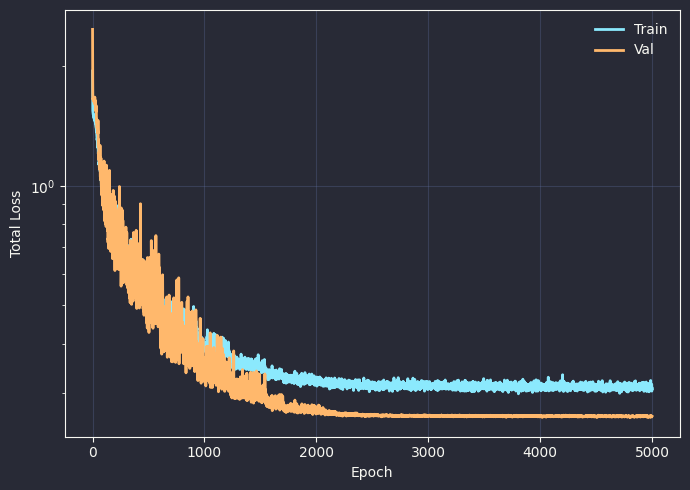

In [49]:
# (Opcional) Plots rápidos
# import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(train_hist, label="Train", lw=2)
plt.plot(val_hist, label="Val", lw=2)
plt.yscale('log')
plt.xlabel("Epoch"); plt.ylabel("Total Loss"); plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()


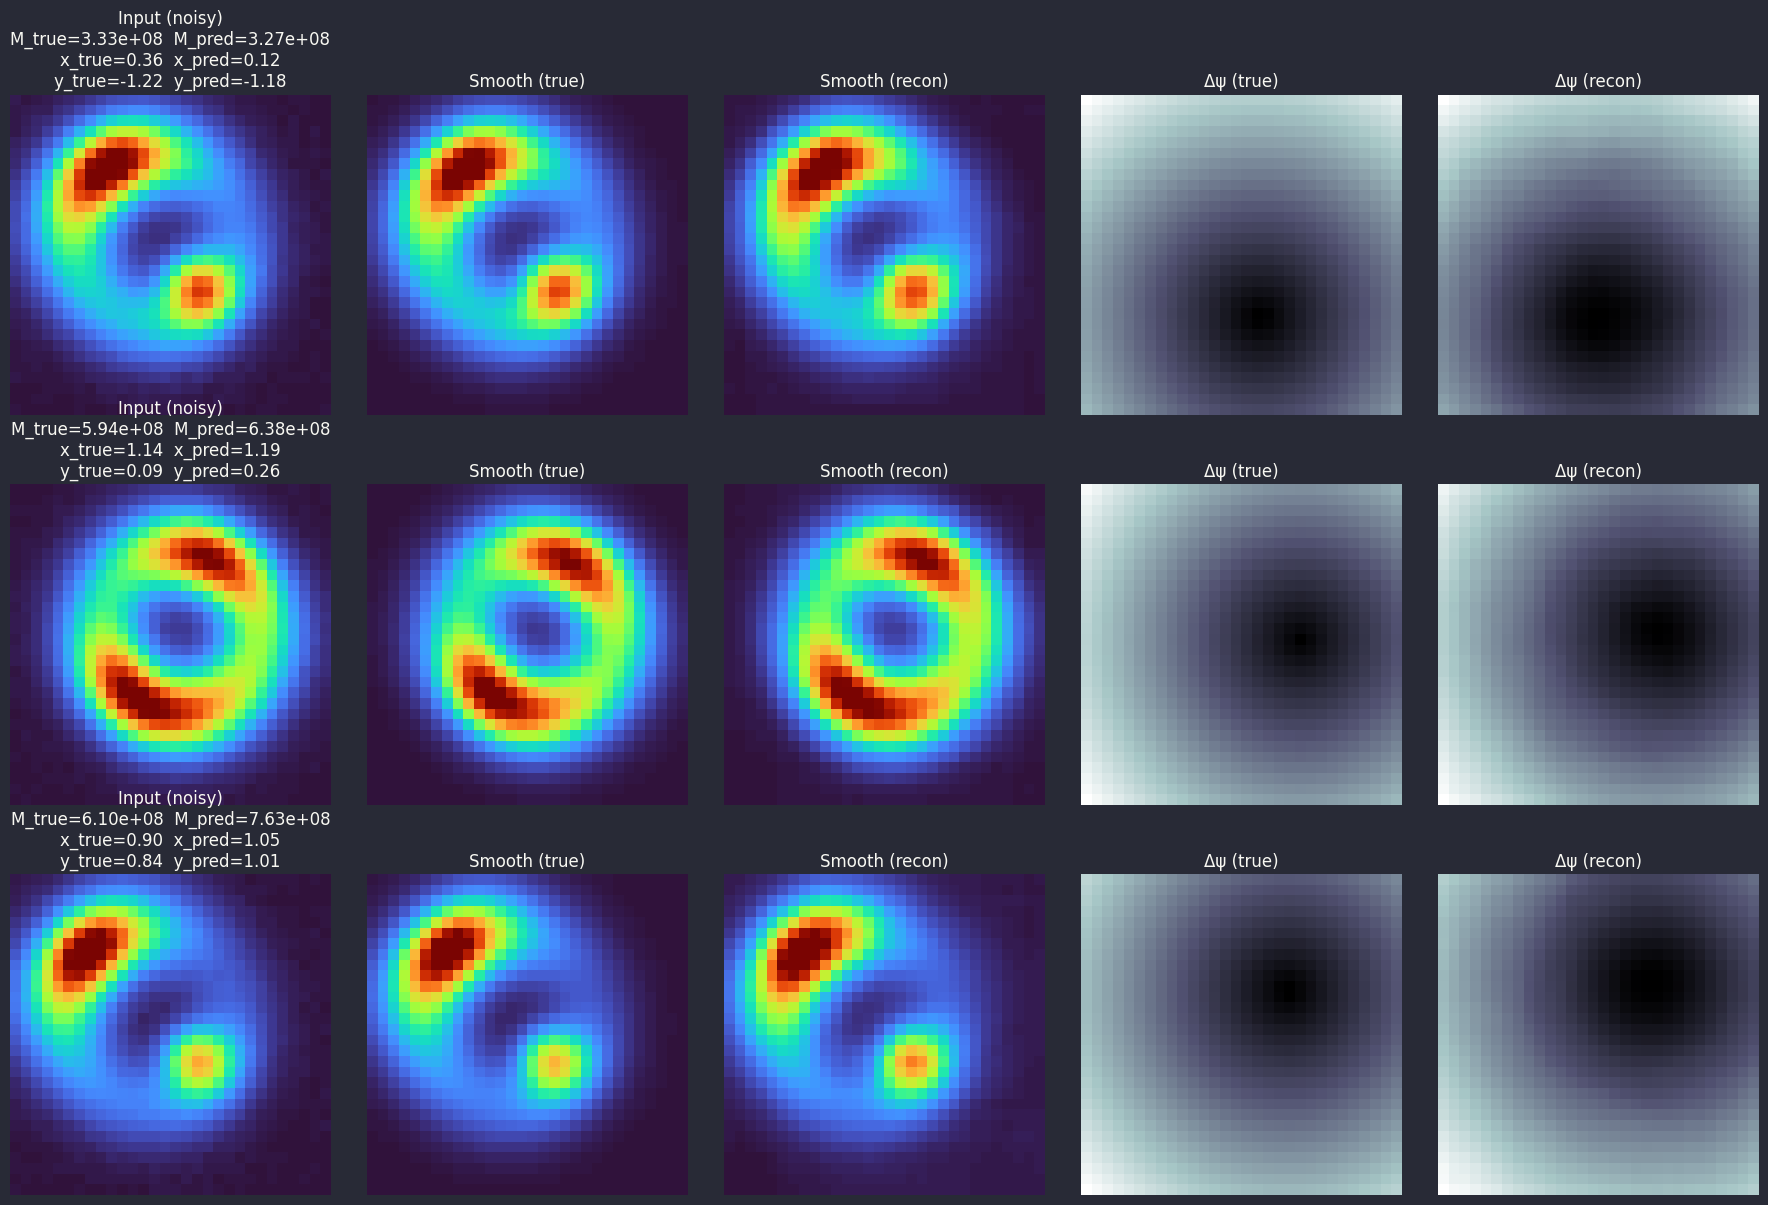

In [50]:
# === Eval + Visualización robusta (maneja norm_stats/mxy_norm_stats ausentes o con nombres viejos) ===
# import torch, numpy as np, matplotlib.pyplot as plt

# -------- helpers --------
def _to01(img, lo=1, hi=99, eps=1e-8):
    p1, p2 = np.percentile(img, (lo, hi))
    if p2 - p1 < eps:
        return np.zeros_like(img)
    return np.clip((img - p1) / (p2 - p1 + eps), 0, 1)

def _get_xy_stats():
    """Obtiene (x_mean,x_std,s_mean,s_std,d_mean,d_std) desde norm_stats o desde tensores de TRAIN.
       Si todo falla, usa mean=0,std=1 para no romper."""
    # 1) norm_stats con claves nuevas
    try:
        return (float(norm_stats["x_mean"]), float(norm_stats["x_std"]),
                float(norm_stats["s_mean"]), float(norm_stats["s_std"]),
                float(norm_stats["d_mean"]), float(norm_stats["d_std"]))
    except Exception:
        pass
    # 2) norm_stats con claves antiguas (ej: 'delta_psi_mean_train')
    try:
        d_mean = float(norm_stats.get("delta_psi_mean_train"))
        d_std  = float(norm_stats.get("delta_psi_std_train"))
        # X/Y1 quizá no existan en esa versión
        # intenta usar variables globales si están
        if 'X_train' in globals() and 'Y1_train' in globals():
            with torch.no_grad():
                x_mean = float(X_train.mean()); x_std = float(X_train.std().clamp_min(1e-6))
                s_mean = float(Y1_train.mean()); s_std = float(Y1_train.std().clamp_min(1e-6))
            return (x_mean, x_std, s_mean, s_std, d_mean, d_std)
    except Exception:
        pass
    # 3) calcula desde tensores TRAIN si existen
    if 'X_train' in globals() and 'Y1_train' in globals() and 'Y2_train' in globals():
        with torch.no_grad():
            x_mean = float(X_train.mean()); x_std = float(X_train.std().clamp_min(1e-6))
            s_mean = float(Y1_train.mean()); s_std = float(Y1_train.std().clamp_min(1e-6))
            d_mean = float(Y2_train.mean()); d_std = float(Y2_train.std().clamp_min(1e-6))
        return (x_mean, x_std, s_mean, s_std, d_mean, d_std)
    # 4) fallback
    return (0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

def _get_mxy_stats():
    """Devuelve (mass_log10_mean, mass_log10_std, x_mean, x_std, y_mean, y_std) para desnormalizar mxy.
       Intenta mxy_norm_stats; si no, calcula desde TRAIN (aplicando log10 a la masa); si falla, identidad."""
    # 1) dict guardado
    try:
        return (float(mxy_norm_stats["mass_log10_mean"]), float(mxy_norm_stats["mass_log10_std"]),
                float(mxy_norm_stats["x_mean"]), float(mxy_norm_stats["x_std"]),
                float(mxy_norm_stats["y_mean"]), float(mxy_norm_stats["y_std"]))
    except Exception:
        pass
    # 2) calcular desde TRAIN si existen tensores crudos (numpy) o tensores normalizados
    try:
        # Si ya tienes mxy_train (normalizado), no se puede recuperar la escala original.
        # Intentamos reconstruir desde arrays crudos si existen:
        if all(k in globals() for k in ("sub_mass_train","sub_x_train","sub_y_train")):
            mass = torch.from_numpy(sub_mass_train).float().clamp_min(1e-12)
            xs   = torch.from_numpy(sub_x_train).float()
            ys   = torch.from_numpy(sub_y_train).float()
            mass_log = torch.log10(mass)
            ml_mean = float(mass_log.mean()); ml_std = float(mass_log.std().clamp_min(1e-6))
            x_mean  = float(xs.mean());       x_std  = float(xs.std().clamp_min(1e-6))
            y_mean  = float(ys.mean());       y_std  = float(ys.std().clamp_min(1e-6))
            return (ml_mean, ml_std, x_mean, x_std, y_mean, y_std)
    except Exception:
        pass
    # 3) fallback identidad
    return (0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

# -------- forward (un batch del test) --------
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x = x.to(device); y_true_smooth = y_true_smooth.to(device)
    y_true_delta = y_true_delta.to(device); mxy_true = mxy_true.to(device)
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# a CPU/NumPy
x_np         = x.detach().cpu().numpy()              # (B,1,H,W) normalizado
y_true_s_np  = y_true_smooth.detach().cpu().numpy()
y_true_d_np  = y_true_delta.detach().cpu().numpy()
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()
mxy_true_np  = mxy_true.detach().cpu().numpy()       # (B,3) normalizado
mxy_pred_np  = mxy_pred.detach().cpu().numpy()

# -------- desnormalización robusta --------
x_mean, x_std, s_mean, s_std, d_mean, d_std = _get_xy_stats()
ml_mean, ml_std, mx_mean, mx_std, my_mean, my_std = _get_mxy_stats()

x_den  = x_np * x_std + x_mean
ys_den = y_true_s_np * s_std + s_mean
ys_hat = y_pred_s_np * s_std + s_mean
yd_den = y_true_d_np * d_std + d_mean
yd_hat = y_pred_d_np * d_std + d_mean

# unstandardize mxy -> (log10(M), x, y)
mxy_true_unstd = mxy_true_np * np.array([ml_std, mx_std, my_std]) + np.array([ml_mean, mx_mean, my_mean])
mxy_pred_unstd = mxy_pred_np * np.array([ml_std, mx_std, my_std]) + np.array([ml_mean, mx_mean, my_mean])
# masa en Msun
M_true = np.power(10.0, mxy_true_unstd[:, 0]); X_true = mxy_true_unstd[:, 1]; Y_true = mxy_true_unstd[:, 2]
M_pred = np.power(10.0, mxy_pred_unstd[:, 0]); X_pred = mxy_pred_unstd[:, 1]; Y_pred = mxy_pred_unstd[:, 2]

# -------- visualización --------
offset    = 0
max_rows  = 3
N         = x_den.shape[0]
n_samples = max(1, min(max_rows, N - offset))

fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4 * n_samples))
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Col 0: Entrada
    ax = axes[i, 0]
    ax.imshow(_to01(x_den[idx, 0]), origin='lower', cmap='turbo')
    ax.set_title(
        "Input (noisy)\n"
        f"M_true={M_true[idx]:.2e}  M_pred={M_pred[idx]:.2e}\n"
        f"x_true={X_true[idx]:.2f}  x_pred={X_pred[idx]:.2f}\n"
        f"y_true={Y_true[idx]:.2f}  y_pred={Y_pred[idx]:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth (true)
    ax = axes[i, 1]
    ax.imshow(_to01(ys_den[idx, 0]), origin='lower', cmap='turbo')
    ax.set_title("Smooth (true)")
    ax.axis('off')

    # Col 2: Smooth (recon)
    ax = axes[i, 2]
    ax.imshow(_to01(ys_hat[idx, 0]), origin='lower', cmap='turbo')
    ax.set_title("Smooth (recon)")
    ax.axis('off')

    # Col 3: Δψ (true)
    ax = axes[i, 3]
    ax.imshow(yd_den[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Δψ (true)")
    ax.axis('off')

    # Col 4: Δψ (recon)
    ax = axes[i, 4]
    ax.imshow(yd_hat[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Δψ (recon)")
    ax.axis('off')

plt.tight_layout()
plt.show()


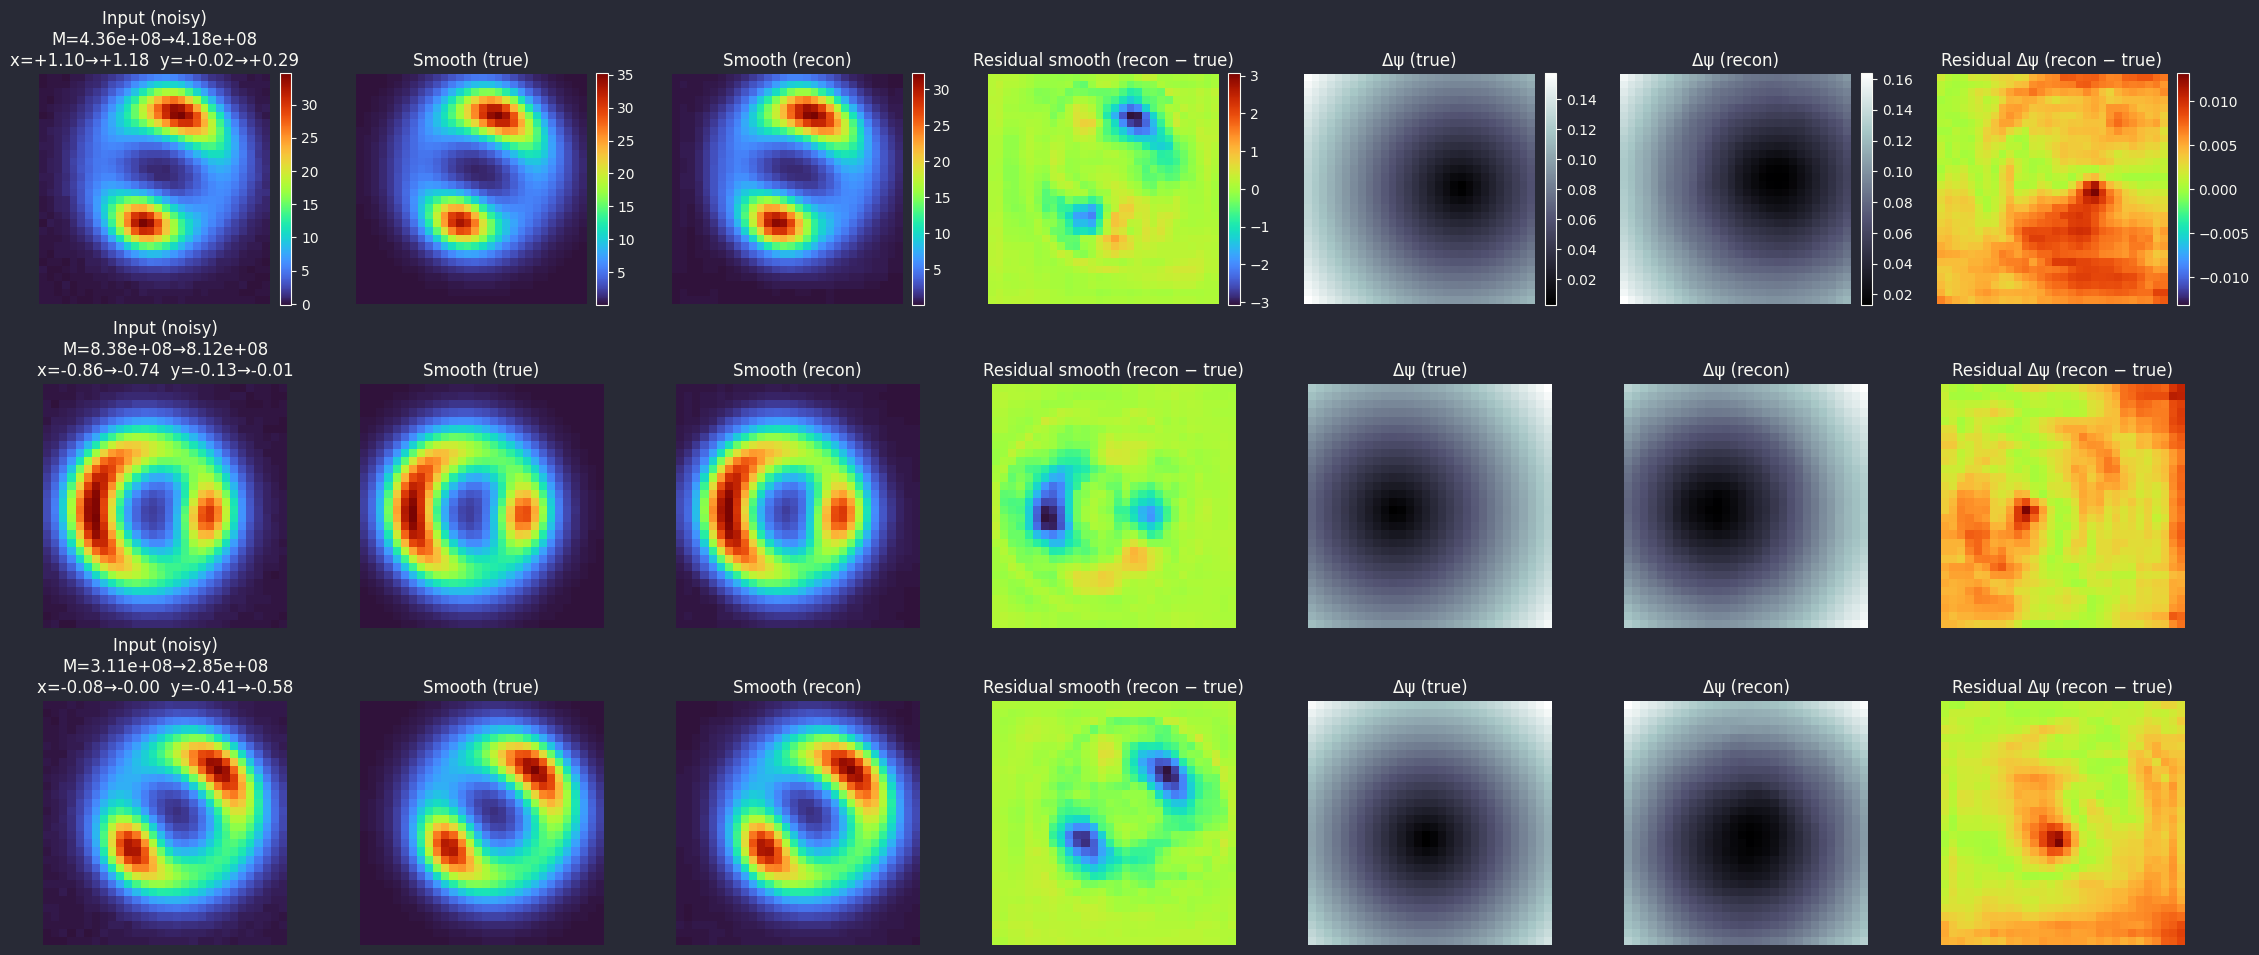

In [51]:
# === Eval + Visualización cruda (sin reescalado/normalización) ===
import torch, numpy as np, matplotlib.pyplot as plt

def _get_xy_stats():
    # (x_mean,x_std,s_mean,s_std,d_mean,d_std) -> si no existen, identidad
    try:
        return (float(norm_stats["x_mean"]), float(norm_stats["x_std"]),
                float(norm_stats["s_mean"]), float(norm_stats["s_std"]),
                float(norm_stats["d_mean"]), float(norm_stats["d_std"]))
    except Exception:
        pass
    if 'X_train' in globals() and 'Y1_train' in globals() and 'Y2_train' in globals():
        with torch.no_grad():
            return (float(X_train.mean()), float(X_train.std().clamp_min(1e-6)),
                    float(Y1_train.mean()), float(Y1_train.std().clamp_min(1e-6)),
                    float(Y2_train.mean()), float(Y2_train.std().clamp_min(1e-6)))
    return (0.,1., 0.,1., 0.,1.)

def _get_mxy_stats():
    try:
        return (float(mxy_norm_stats["mass_log10_mean"]), float(mxy_norm_stats["mass_log10_std"]),
                float(mxy_norm_stats["x_mean"]), float(mxy_norm_stats["x_std"]),
                float(mxy_norm_stats["y_mean"]), float(mxy_norm_stats["y_std"]))
    except Exception:
        pass
    if all(k in globals() for k in ("sub_mass_train","sub_x_train","sub_y_train")):
        mass_log = np.log10(np.clip(sub_mass_train, 1e-12, None)).astype(np.float64)
        return (float(mass_log.mean()), float(max(mass_log.std(), 1e-6)),
                float(sub_x_train.mean()), float(max(sub_x_train.std(), 1e-6)),
                float(sub_y_train.mean()), float(max(sub_y_train.std(), 1e-6)))
    return (0.,1., 0.,1., 0.,1.)

# ----- forward de un batch -----
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x = x.to(device); y_true_smooth = y_true_smooth.to(device)
    y_true_delta = y_true_delta.to(device); mxy_true = mxy_true.to(device)
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# a numpy
x_np        = x.cpu().numpy()              # (B,1,H,W)
ys_true_np  = y_true_smooth.cpu().numpy()
yd_true_np  = y_true_delta.cpu().numpy()
ys_pred_np  = y_pred_smooth.cpu().numpy()
yd_pred_np  = y_pred_delta.cpu().numpy()
mxy_true_np = mxy_true.cpu().numpy()       # (B,3) normalizado
mxy_pred_np = mxy_pred.cpu().numpy()

# desnormalización (si hay stats); NO se cambia el rango de las imágenes
x_mean, x_std, s_mean, s_std, d_mean, d_std = _get_xy_stats()
ml_mean, ml_std, mx_mean, mx_std, my_mean, my_std = _get_mxy_stats()

x_den   = x_np * x_std + x_mean
ys_true = ys_true_np * s_std + s_mean
ys_pred = ys_pred_np * s_std + s_mean
yd_true = yd_true_np * d_std + d_mean
yd_pred = yd_pred_np * d_std + d_mean

mxy_true_un = mxy_true_np * np.array([ml_std, mx_std, my_std]) + np.array([ml_mean, mx_mean, my_mean])
mxy_pred_un = mxy_pred_np * np.array([ml_std, mx_std, my_std]) + np.array([ml_mean, mx_mean, my_mean])
M_true = 10.0**mxy_true_un[:,0]; X_true = mxy_true_un[:,1]; Y_true = mxy_true_un[:,2]
M_pred = 10.0**mxy_pred_un[:,0]; X_pred = mxy_pred_un[:,1]; Y_pred = mxy_pred_un[:,2]

# selección aleatoria dentro del batch
B = x_den.shape[0]
rows = min(3, B)
rng  = np.random.default_rng()
sel  = rng.choice(np.arange(B), size=rows, replace=False)

# figura: 7 columnas (input, smooth true, smooth recon, residual smooth, ψ true, ψ recon, residual ψ)
ncols = 7
fig, axes = plt.subplots(rows, ncols, figsize=(3.2*ncols, 3.2*rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, idx in enumerate(sel):
    inp   = x_den[idx, 0]
    s_t   = ys_true[idx, 0]
    s_p   = ys_pred[idx, 0]
    d_t   = yd_true[idx, 0]
    d_p   = yd_pred[idx, 0]

    res_s = s_p - s_t
    res_d = d_p - d_t
    lim_s = np.max(np.abs(res_s)); lim_s = float(lim_s if lim_s > 0 else 1.0)
    lim_d = np.max(np.abs(res_d)); lim_d = float(lim_d if lim_d > 0 else 1.0)

    # (0) input
    ax = axes[r, 0]
    im = ax.imshow(inp, origin='lower', cmap='turbo')     # SIN reescalar valores
    ax.set_title(f"Input (noisy)\nM={M_true[idx]:.2e}→{M_pred[idx]:.2e}\n"
                 f"x={X_true[idx]:+.2f}→{X_pred[idx]:+.2f}  y={Y_true[idx]:+.2f}→{Y_pred[idx]:+.2f}")
    ax.axis('off')
    # opcional: barra solo en la primera fila
    if r == 0:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # (1) smooth true
    ax = axes[r, 1]; im = ax.imshow(s_t, origin='lower', cmap='turbo'); ax.set_title("Smooth (true)"); ax.axis('off')
    if r == 0: plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # (2) smooth recon
    ax = axes[r, 2]; im = ax.imshow(s_p, origin='lower', cmap='turbo'); ax.set_title("Smooth (recon)"); ax.axis('off')
    if r == 0: plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # (3) residual smooth
    ax = axes[r, 3]; im = ax.imshow(res_s, origin='lower', cmap='turbo', vmin=-lim_s, vmax=+lim_s)
    ax.set_title("Residual smooth (recon − true)"); ax.axis('off')
    if r == 0: plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # (4) ψ true
    ax = axes[r, 4]; im = ax.imshow(d_t, origin='lower', cmap='bone'); ax.set_title("Δψ (true)"); ax.axis('off')
    if r == 0: plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # (5) ψ recon
    ax = axes[r, 5]; im = ax.imshow(d_p, origin='lower', cmap='bone'); ax.set_title("Δψ (recon)"); ax.axis('off')
    if r == 0: plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # (6) residual ψ
    ax = axes[r, 6]; im = ax.imshow(abs(res_d), origin='lower', cmap='turbo', vmin=-lim_d, vmax=+lim_d)
    ax.set_title("Residual Δψ (recon − true)"); ax.axis('off')
    if r == 0: plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


======== Image reconstruction metrics (per-image) ========
[MSE_smooth]  mean=5.8108e-01  median=3.0638e-01  std=6.8848e-01  p16=1.6975e-01  p84=1.0321e+00
[MAE_smooth]  mean=3.8985e-01  median=3.1127e-01  std=2.0404e-01  p16=2.4098e-01  p84=5.6065e-01
[MSE_deltaPsi]  mean=2.0179e-04  median=8.2715e-05  std=3.5734e-04  p16=2.5104e-05  p84=3.1715e-04
[MAE_deltaPsi]  mean=1.0006e-02  median=7.8922e-03  std=7.2936e-03  p16=4.1546e-03  p84=1.5489e-02


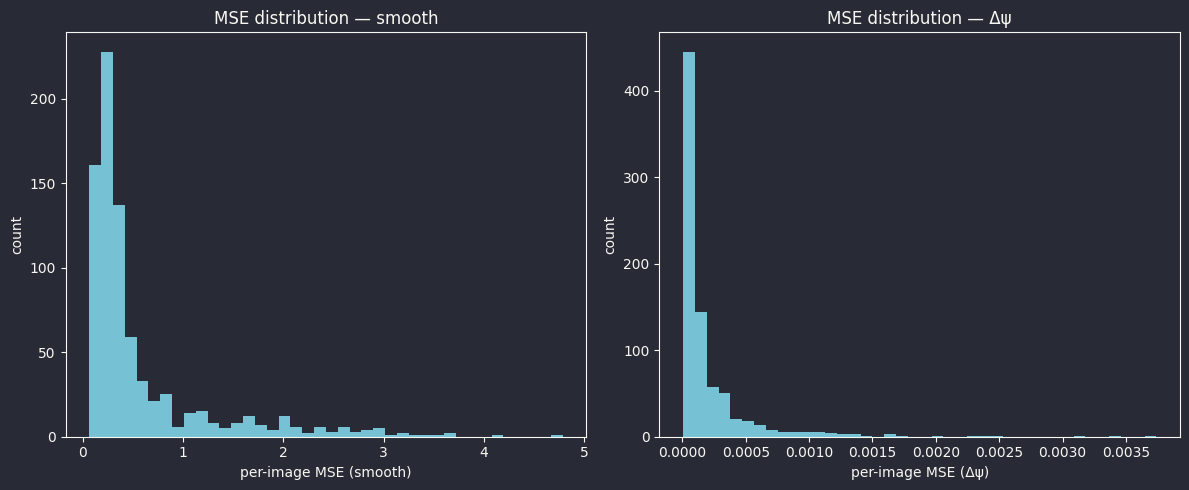

In [52]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# --- helpers reutilizados ---
def _get_xy_stats():
    """Obtiene (x_mean,x_std,s_mean,s_std,d_mean,d_std) desde norm_stats o desde tensores de TRAIN."""
    try:
        return (float(norm_stats["x_mean"]), float(norm_stats["x_std"]),
                float(norm_stats["s_mean"]), float(norm_stats["s_std"]),
                float(norm_stats["d_mean"]), float(norm_stats["d_std"]))
    except Exception:
        pass
    # fallback: calcula desde TRAIN si existen
    if 'X_train' in globals() and 'Y1_train' in globals() and 'Y2_train' in globals():
        with torch.no_grad():
            x_mean = float(X_train.mean()); x_std = float(X_train.std().clamp_min(1e-6))
            s_mean = float(Y1_train.mean()); s_std = float(Y1_train.std().clamp_min(1e-6))
            d_mean = float(Y2_train.mean()); d_std = float(Y2_train.std().clamp_min(1e-6))
        return (x_mean, x_std, s_mean, s_std, d_mean, d_std)
    # último recurso
    return (0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

x_mean, x_std, s_mean, s_std, d_mean, d_std = _get_xy_stats()

model.eval()
mse_s_list, mae_s_list = [], []
mse_d_list, mae_d_list = [], []

with torch.no_grad():
    for x, y_s, y_d, _ in test_loader:
        x   = x.to(device).float()
        y_s = y_s.to(device).float()
        y_d = y_d.to(device).float()

        y_s_pred, y_d_pred, _, _, _ = model(x)

        # desnormaliza a espacio físico
        y_s_true_den = y_s.detach().cpu().numpy() * s_std + s_mean   # (B,1,H,W)
        y_s_pred_den = y_s_pred.detach().cpu().numpy() * s_std + s_mean
        y_d_true_den = y_d.detach().cpu().numpy() * d_std + d_mean
        y_d_pred_den = y_d_pred.detach().cpu().numpy() * d_std + d_mean

        # per-image MSE/MAE
        diff_s = y_s_pred_den - y_s_true_den
        diff_d = y_d_pred_den - y_d_true_den

        mse_s_batch = np.mean(diff_s**2, axis=(1,2,3))
        mae_s_batch = np.mean(np.abs(diff_s), axis=(1,2,3))
        mse_d_batch = np.mean(diff_d**2, axis=(1,2,3))
        mae_d_batch = np.mean(np.abs(diff_d), axis=(1,2,3))

        mse_s_list.append(mse_s_batch)
        mae_s_list.append(mae_s_batch)
        mse_d_list.append(mse_d_batch)
        mae_d_list.append(mae_d_batch)

mse_s_all = np.concatenate(mse_s_list)
mae_s_all = np.concatenate(mae_s_list)
mse_d_all = np.concatenate(mse_d_list)
mae_d_all = np.concatenate(mae_d_list)

def _summ_stats(arr, name):
    print(f"[{name}]  mean={arr.mean():.4e}  median={np.median(arr):.4e}  "
          f"std={arr.std():.4e}  p16={np.percentile(arr,16):.4e}  p84={np.percentile(arr,84):.4e}")

print("======== Image reconstruction metrics (per-image) ========")
_summ_stats(mse_s_all, "MSE_smooth")
_summ_stats(mae_s_all, "MAE_smooth")
_summ_stats(mse_d_all, "MSE_deltaPsi")
_summ_stats(mae_d_all, "MAE_deltaPsi")

# --- Histogramas de MSE por imagen ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].hist(mse_s_all, bins=40, alpha=0.8)
axes[0].set_xlabel("per-image MSE (smooth)")
axes[0].set_ylabel("count")
axes[0].set_title("MSE distribution — smooth")

axes[1].hist(mse_d_all, bins=40, alpha=0.8)
axes[1].set_xlabel("per-image MSE (Δψ)")
axes[1].set_ylabel("count")
axes[1].set_title("MSE distribution — Δψ")

plt.tight_layout()
plt.show()


======= Regression metrics (physical units) =======
[Mass (Msun)]   MSE=1.2901e+16  MAE=8.2050e+07  R²=0.7866
[log10(Mass)]   MSE=8.1073e-03  MAE=6.8190e-02  R²=0.8550
[x (arcsec)]    MSE=8.8831e-02  MAE=2.2998e-01  R²=0.8814
[y (arcsec)]    MSE=6.2667e-02  MAE=1.9097e-01  R²=0.9088

======= Error stats (Δ = pred - true) =======
log10(M): mean=-0.009, std=0.090, p16=-0.090, p50=-0.012, p84=0.071
x [arcsec]: mean=0.005, std=0.298, p16=-0.267, p50=0.017, p84=0.285
y [arcsec]: mean=0.014, std=0.250, p16=-0.213, p50=0.009, p84=0.236


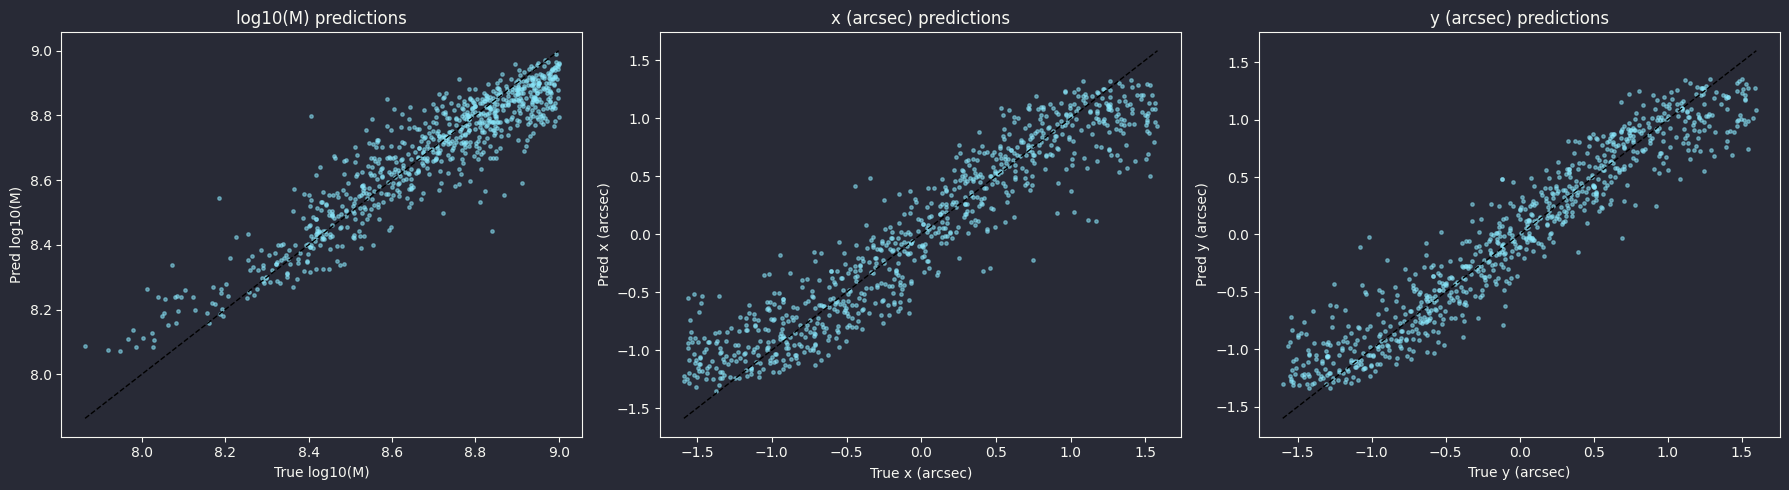

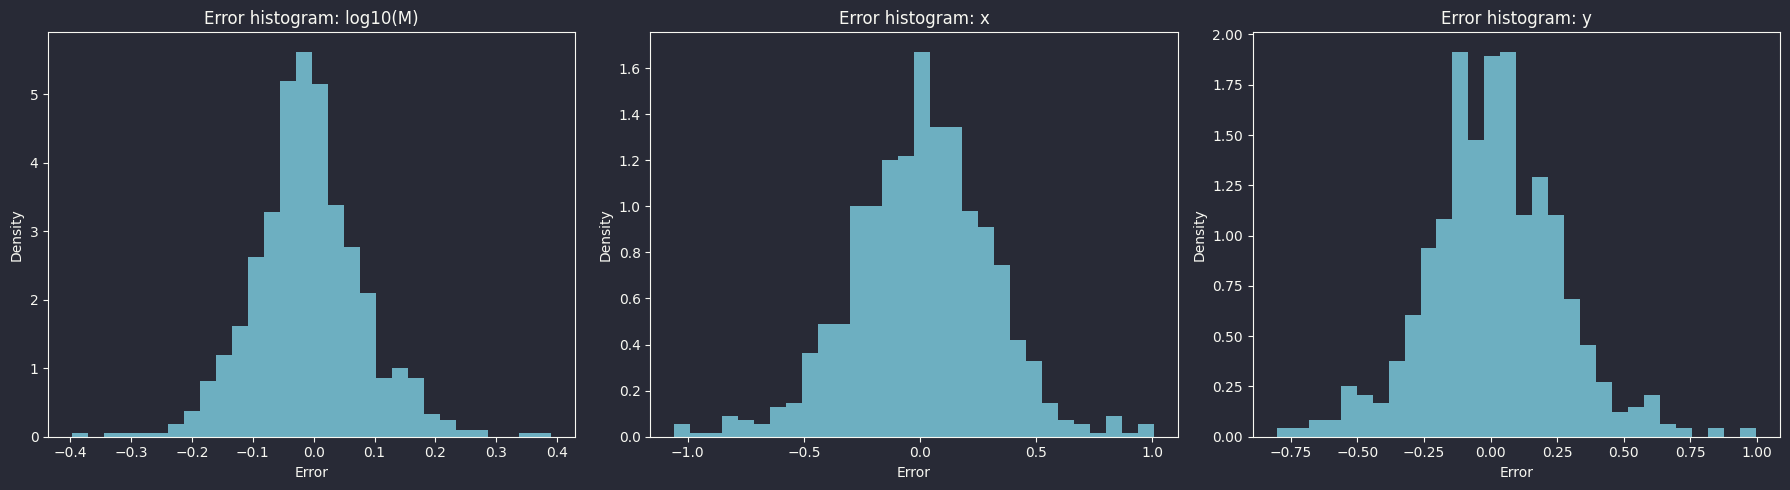

In [53]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # === 1) Stats de desnormalización para mxy ===
# def _get_mxy_stats():
#     # Preferimos las claves de mxy_norm_stats (log10(mass) + estándar por TRAIN)
#     try:
#         ml_mean = float(mxy_norm_stats["mass_log10_mean"])
#         ml_std  = float(mxy_norm_stats["mass_log10_std"])
#         x_mean  = float(mxy_norm_stats["x_mean"]); x_std = float(mxy_norm_stats["x_std"])
#         y_mean  = float(mxy_norm_stats["y_mean"]); y_std = float(mxy_norm_stats["y_std"])
#         return (ml_mean, ml_std, x_mean, x_std, y_mean, y_std)
#     except Exception:
#         pass
#     # Fallback: calcula desde TRAIN crudo si está en memoria
#     mass = torch.from_numpy(sub_mass_train).float().clamp_min(1e-12)
#     xs   = torch.from_numpy(sub_x_train).float()
#     ys   = torch.from_numpy(sub_y_train).float()
#     mass_log = torch.log10(mass)
#     ml_mean = float(mass_log.mean()); ml_std = float(mass_log.std().clamp_min(1e-6))
#     x_mean  = float(xs.mean());       x_std  = float(xs.std().clamp_min(1e-6))
#     y_mean  = float(ys.mean());       y_std  = float(ys.std().clamp_min(1e-6))
#     return (ml_mean, ml_std, x_mean, x_std, y_mean, y_std)

# ml_mean, ml_std, x_mean, x_std, y_mean, y_std = _get_mxy_stats()
# mxy_mean_vec = np.array([ml_mean, x_mean, y_mean])
# mxy_std_vec  = np.array([ml_std,  x_std,  y_std ])

# # === 2) Eval loop (recoge pred/true NORMALIZADOS del loader) ===
# model.eval()
# pred_list, true_list = [], []
# with torch.no_grad():
#     for x, _, _, mxy_true in test_loader:
#         x = x.to(device)
#         _, _, _, _, mxy_pred = model(x)
#         pred_list.append(mxy_pred.detach().cpu().numpy())  # (B,3) normalizado
#         true_list.append(mxy_true.detach().cpu().numpy())  # (B,3) normalizado

# all_pred_n = np.vstack(pred_list)  # logM,z-norm ; x,y-norm
# all_true_n = np.vstack(true_list)

# # === 3) Desnormaliza a espacio de entrenamiento: (log10(M), x, y) ===
# all_pred_unstd = all_pred_n * mxy_std_vec + mxy_mean_vec
# all_true_unstd = all_true_n * mxy_std_vec + mxy_mean_vec

# # === 4) Masa en Msun para métricas físicas; x,y ya están en arcsec
# mass_true_log = all_true_unstd[:, 0]
# mass_pred_log = all_pred_unstd[:, 0]
# mass_true = np.power(10.0, mass_true_log)
# mass_pred = np.power(10.0, mass_pred_log)

# x_true, y_true = all_true_unstd[:, 1], all_true_unstd[:, 2]
# x_pred, y_pred = all_pred_unstd[:, 1], all_pred_unstd[:, 2]

# # === 5) Métricas: reporta en Msun para masa + también en log10(mass) por estabilidad ===
# def _metrics(y_t, y_p):
#     return (mean_squared_error(y_t, y_p),
#             mean_absolute_error(y_t, y_p),
#             r2_score(y_t, y_p))

# mse_M, mae_M, r2_M       = _metrics(mass_true, mass_pred)
# mse_logM, mae_logM, r2_l = _metrics(mass_true_log, mass_pred_log)
# mse_x, mae_x, r2_x       = _metrics(x_true, x_pred)
# mse_y, mae_y, r2_y       = _metrics(y_true, y_pred)

# print("[Mass (Msun)]   MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_M, mae_M, r2_M))
# print("[log10(Mass)]   MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_logM, mae_logM, r2_l))
# print("[x (arcsec)]    MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_x, mae_x, r2_x))
# print("[y (arcsec)]    MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_y, mae_y, r2_y))

# # === 6) Scatter plots: log10(M), x, y ===
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# pairs = [
#     (mass_true_log, mass_pred_log, "log10(M)"),
#     (x_true, x_pred, "x (arcsec)"),
#     (y_true, y_pred, "y (arcsec)"),
# ]
# for ax, (yt, yp, name) in zip(axes, pairs):
#     ax.scatter(yt, yp, s=6, alpha=0.5)
#     mn, mx = float(min(yt.min(), yp.min())), float(max(yt.max(), yp.max()))
#     ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
#     ax.set_xlabel(f"True {name}")
#     ax.set_ylabel(f"Pred {name}")
#     ax.set_title(f"{name} predictions")
# plt.tight_layout(); plt.show()

# # === 7) Histogramas de error (en los mismos espacios que los plots) ===
# err_logM = mass_pred_log - mass_true_log
# err_x = x_pred - x_true
# err_y = y_pred - y_true

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# axes[0].hist(err_logM, bins=30, density=True, alpha=0.7); axes[0].set_title("Error histogram: log10(M)")
# axes[1].hist(err_x,    bins=30, density=True, alpha=0.7); axes[1].set_title("Error histogram: x")
# axes[2].hist(err_y,    bins=30, density=True, alpha=0.7); axes[2].set_title("Error histogram: y")
# for ax in axes:
#     ax.set_xlabel("Error"); ax.set_ylabel("Density")
# plt.tight_layout(); plt.show()

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === 1) Stats de desnormalización para mxy ===
def _get_mxy_stats():
    # Preferimos las claves de mxy_norm_stats (log10(mass) + estándar por TRAIN)
    try:
        ml_mean = float(mxy_norm_stats["mass_log10_mean"])
        ml_std  = float(mxy_norm_stats["mass_log10_std"])
        x_mean  = float(mxy_norm_stats["x_mean"]); x_std = float(mxy_norm_stats["x_std"])
        y_mean  = float(mxy_norm_stats["y_mean"]); y_std = float(mxy_norm_stats["y_std"])
        return (ml_mean, ml_std, x_mean, x_std, y_mean, y_std)
    except Exception:
        pass
    # Fallback: calcula desde TRAIN crudo si está en memoria
    mass = torch.from_numpy(sub_mass_train).float().clamp_min(1e-12)
    xs   = torch.from_numpy(sub_x_train).float()
    ys   = torch.from_numpy(sub_y_train).float()
    mass_log = torch.log10(mass)
    ml_mean = float(mass_log.mean()); ml_std = float(mass_log.std().clamp_min(1e-6))
    x_mean  = float(xs.mean());       x_std  = float(xs.std().clamp_min(1e-6))
    y_mean  = float(ys.mean());       y_std  = float(ys.std().clamp_min(1e-6))
    return (ml_mean, ml_std, x_mean, x_std, y_mean, y_std)

ml_mean, ml_std, x_mean, x_std, y_mean, y_std = _get_mxy_stats()
mxy_mean_vec = np.array([ml_mean, x_mean, y_mean])
mxy_std_vec  = np.array([ml_std,  x_std,  y_std ])

# === 2) Eval loop (pred/true NORMALIZADOS del loader) ===
model.eval()
pred_list, true_list = [], []
with torch.no_grad():
    for x, _, _, mxy_true in test_loader:
        x = x.to(device)
        _, _, _, _, mxy_pred = model(x)
        pred_list.append(mxy_pred.detach().cpu().numpy())  # (B,3) normalizado
        true_list.append(mxy_true.detach().cpu().numpy())  # (B,3) normalizado

all_pred_n = np.vstack(pred_list)  # logM,x,y norm
all_true_n = np.vstack(true_list)

# === 3) Desnormaliza a espacio de entrenamiento: (log10(M), x, y) ===
all_pred_unstd = all_pred_n * mxy_std_vec + mxy_mean_vec
all_true_unstd = all_true_n * mxy_std_vec + mxy_mean_vec

# === 4) Masa en Msun para métricas físicas; x,y ya están en arcsec ===
mass_true_log = all_true_unstd[:, 0]
mass_pred_log = all_pred_unstd[:, 0]
mass_true = np.power(10.0, mass_true_log)
mass_pred = np.power(10.0, mass_pred_log)

x_true, y_true = all_true_unstd[:, 1], all_true_unstd[:, 2]
x_pred, y_pred = all_pred_unstd[:, 1], all_pred_unstd[:, 2]

# === 5) Métricas principales ===
def _metrics(y_t, y_p):
    return (mean_squared_error(y_t, y_p),
            mean_absolute_error(y_t, y_p),
            r2_score(y_t, y_p))

mse_M,   mae_M,   r2_M   = _metrics(mass_true, mass_pred)
mse_logM,mae_logM,r2_l   = _metrics(mass_true_log, mass_pred_log)
mse_x,   mae_x,   r2_x   = _metrics(x_true, x_pred)
mse_y,   mae_y,   r2_y   = _metrics(y_true, y_pred)

# === 5b) Errores y dispersión (σ, percentiles) ===
err_logM = mass_pred_log - mass_true_log
err_x    = x_pred - x_true
err_y    = y_pred - y_true

def _err_stats(e):
    return dict(
        mean=float(np.mean(e)),
        std=float(np.std(e)),
        p16=float(np.percentile(e, 16)),
        p50=float(np.percentile(e, 50)),
        p84=float(np.percentile(e, 84))
    )

stats_logM = _err_stats(err_logM)
stats_x    = _err_stats(err_x)
stats_y    = _err_stats(err_y)

print("======= Regression metrics (physical units) =======")
print("[Mass (Msun)]   MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_M, mae_M, r2_M))
print("[log10(Mass)]   MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_logM, mae_logM, r2_l))
print("[x (arcsec)]    MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_x, mae_x, r2_x))
print("[y (arcsec)]    MSE=%.4e  MAE=%.4e  R²=%.4f" % (mse_y, mae_y, r2_y))

print("\n======= Error stats (Δ = pred - true) =======")
print("log10(M): mean={mean:.3f}, std={std:.3f}, p16={p16:.3f}, p50={p50:.3f}, p84={p84:.3f}"
      .format(**stats_logM))
print("x [arcsec]: mean={mean:.3f}, std={std:.3f}, p16={p16:.3f}, p50={p50:.3f}, p84={p84:.3f}"
      .format(**stats_x))
print("y [arcsec]: mean={mean:.3f}, std={std:.3f}, p16={p16:.3f}, p50={p50:.3f}, p84={p84:.3f}"
      .format(**stats_y))

# === 6) Scatter plots: log10(M), x, y ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pairs = [
    (mass_true_log, mass_pred_log, "log10(M)"),
    (x_true, x_pred, "x (arcsec)"),
    (y_true, y_pred, "y (arcsec)"),
]
for ax, (yt, yp, name) in zip(axes, pairs):
    ax.scatter(yt, yp, s=6, alpha=0.5)
    mn, mx = float(min(yt.min(), yp.min())), float(max(yt.max(), yp.max()))
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
    ax.set_xlabel(f"True {name}")
    ax.set_ylabel(f"Pred {name}")
    ax.set_title(f"{name} predictions")
plt.tight_layout(); plt.show()

# === 7) Histogramas de error (en los mismos espacios que los plots) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(err_logM, bins=30, density=True, alpha=0.7); axes[0].set_title("Error histogram: log10(M)")
axes[1].hist(err_x,    bins=30, density=True, alpha=0.7); axes[1].set_title("Error histogram: x")
axes[2].hist(err_y,    bins=30, density=True, alpha=0.7); axes[2].set_title("Error histogram: y")
for ax in axes:
    ax.set_xlabel("Error"); ax.set_ylabel("Density")
plt.tight_layout(); plt.show()


In [54]:
# save model
# torch.save(model.state_dict(), 'dual_vae_subset_2.pth')
   
